# Notebook 2: HMM Training, Analysis, and Visualization

**Objective:** Load the logged inference trajectories, train an HMM surrogate, analyze its learned states, and visualize its behavior on test reviews.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle # to save data for clustering

# Add src directory to Python path

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.config import (
    LOG_FILE_PATH, HMM_MODEL_PATH, TARGET_SENTIMENT,
    NUM_TEST_SAMPLES, MAX_TOKENS, MODEL_NAME, DEVICE, 
    COLOR_LOG_FILE_PATH
)
from src.hmm_surrogate import HMMSurrogate
from src.data_utils import load_imdb_data, preprocess_data_for_inference_logging
from src.black_box_model import BlackBoxSentimentClassifier, log_inference_trajectories
from src.visualization_utils import plot_state_timeline, plot_hmm_transition_matrix, plot_avg_probabilities_per_state
from src.clustering_utils import save_color_log
%matplotlib inline

/home/gamerio/miniconda3/envs/playground/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Logged Inference Trajectories

In [2]:
try:
    loaded_data = np.load(LOG_FILE_PATH)
    train_trajectories = [loaded_data[f'arr_{i}'] for i in range(len(loaded_data.files))]
    print(f"Loaded {len(train_trajectories)} trajectories from {LOG_FILE_PATH}.")
    if train_trajectories:
        print(f"Example trajectory 0 shape: {train_trajectories[0].shape}")
except FileNotFoundError:
    print(f"Error: Log file {LOG_FILE_PATH} not found. Please run Notebook 1 first.")
    train_trajectories = []

Loaded 25000 trajectories from data/imbd_inference_logs25k.npz.
Example trajectory 0 shape: (512, 2)


## 2. Train HMM Surrogate

In [ ]:
hmm_surrogate_model = None
if train_trajectories:
    hmm_surrogate_model = HMMSurrogate() # Uses N_HMM_STATES from config
    hmm_surrogate_model.train(train_trajectories)
    
    # Save the trained HMM model
    if not os.path.exists('models'):
        os.makedirs('models')
    hmm_surrogate_model.save_model(HMM_MODEL_PATH)
else:
    print("Skipping HMM training as no trajectories were loaded.")

In [3]:
hmm_surrogate_model=HMMSurrogate().load_model("models/sentiment_hmm25k_3states.pkl")

HMM model loaded from models/sentiment_hmm25k_3states.pkl


## 3. Analyze HMM Parameters and States

If you didn't just train, you can load a pre-trained HMM model.


--- HMM State Analysis ---
State 0: Occurrences = 2151248, Avg. P(Class 1) = 0.013
State 1: Occurrences = 2193767, Avg. P(Class 1) = 0.983
State 2: Occurrences = 2537571, Avg. P(Class 1) = 0.506

Suggested State Interpretations (based on P(Class {target_class_idx})):
  HMM State 0: ~Leaning Negative/Low Confidence (Avg. P(Class 1) = 0.013)
  HMM State 2: ~Neutral/Uncertain (Avg. P(Class 1) = 0.506)
  HMM State 1: ~Leaning Positive/High Confidence (Avg. P(Class 1) = 0.983)


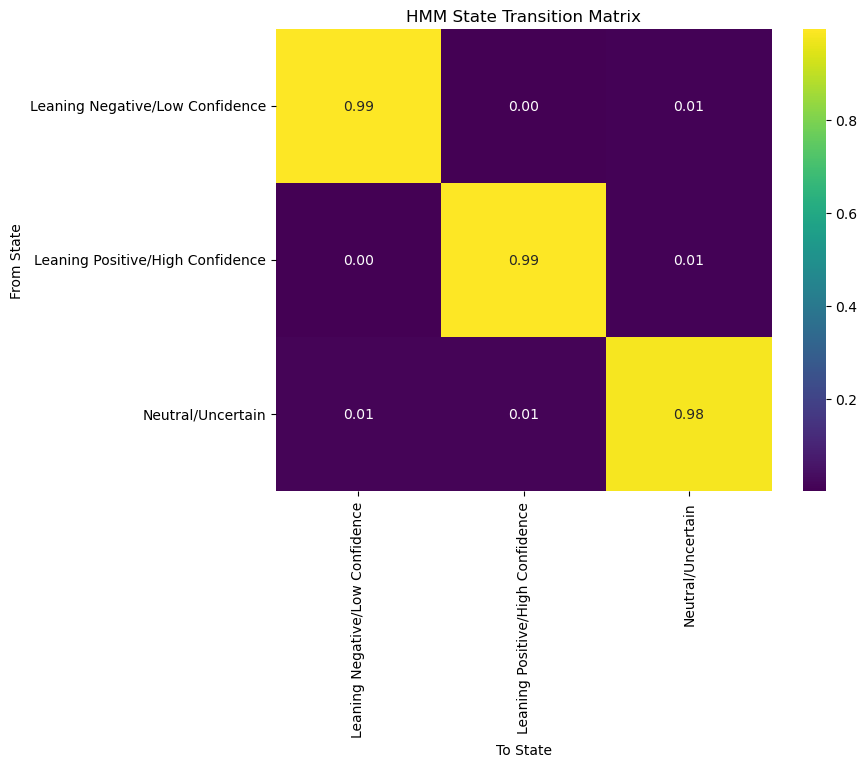

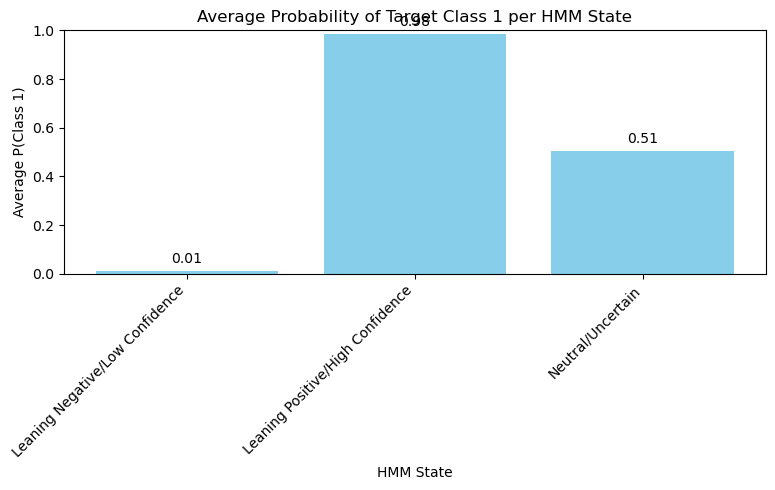

In [4]:
if hmm_surrogate_model is None or not hmm_surrogate_model.is_trained:
    print(f"Attempting to load pre-trained HMM from {HMM_MODEL_PATH}")
    try:
        hmm_surrogate_model = HMMSurrogate()
        hmm_surrogate_model.load_model(HMM_MODEL_PATH)
    except FileNotFoundError:
        print(f"Error: Pre-trained HMM model not found at {HMM_MODEL_PATH}. Please train one first.")
        hmm_surrogate_model = None # Ensure it's None if loading fails

state_analysis_results = None
if hmm_surrogate_model and hmm_surrogate_model.is_trained and train_trajectories:
    # For state analysis, we need decoded states for the training trajectories
    decoded_train_states = [hmm_surrogate_model.decode_sequence(traj) for traj in train_trajectories if traj.shape[0] > 0]
    
    # Filter out empty sequences from train_trajectories if their decoded_train_states are empty
    valid_train_trajectories = [traj for traj, states in zip(train_trajectories, decoded_train_states) if states.size > 0]
    valid_decoded_train_states = [states for states in decoded_train_states if states.size > 0]

    state_analysis_results = hmm_surrogate_model.analyze_states(
        valid_train_trajectories, 
        valid_decoded_train_states, 
        target_class_idx=TARGET_SENTIMENT
    )
    
    # Visualize HMM parameters
    plot_hmm_transition_matrix(hmm_surrogate_model.model, state_names=state_analysis_results.get('state_names'))
    plot_avg_probabilities_per_state(state_analysis_results, target_class_idx=TARGET_SENTIMENT)

## 4. Visualize HMM Behavior on Test Reviews

Load a few test reviews, get their black-box probability trajectories, decode HMM states, and plot.

In [6]:
import pickle

In [7]:
# create global variable to log when the state changes at a word level
color_transitions_log = []


--- Visualizing HMM on Test Reviews ---
Model loaded successfully on cuda
loaded black box model: lvwerra/distilbert-imdb
Labels: {0: 'NEGATIVE', 1: 'POSITIVE'}


Processing data: 100%|██████████| 20/20 [00:29<00:00,  1.49s/it]



Visualizing Test Sample 1:
Text: I just finished watching this movie and am disappointed to say that I didn't enjoy it a bit. It is so slow Slow and uninteresting. This kid from Harry Potter plays a shy teenager with an rude mother, ...

Sentence tokens with HMM colors:
[CLS] i just finished watching this movie and am disappointed to say that i didn ' t enjoy it a bit . it is so slow slow and un ##int ##eres ##ting . this kid from harry potter plays a shy teenager with an rude mother , and then one day the rude mother tells the kid to find a job so that they could accommodate an old guy apparently having no place to live has started to live with his family and therefore the kid goes to work for a old lady . and this old lady who is living all alone teaches him about girls , driving car and life ! i couldn ' t get how an 18 year old guy enjoy spending time with an awful lady in her 80s . sorry if my comments on this movie has bothered people who might have enjoyed it , i could be wrong

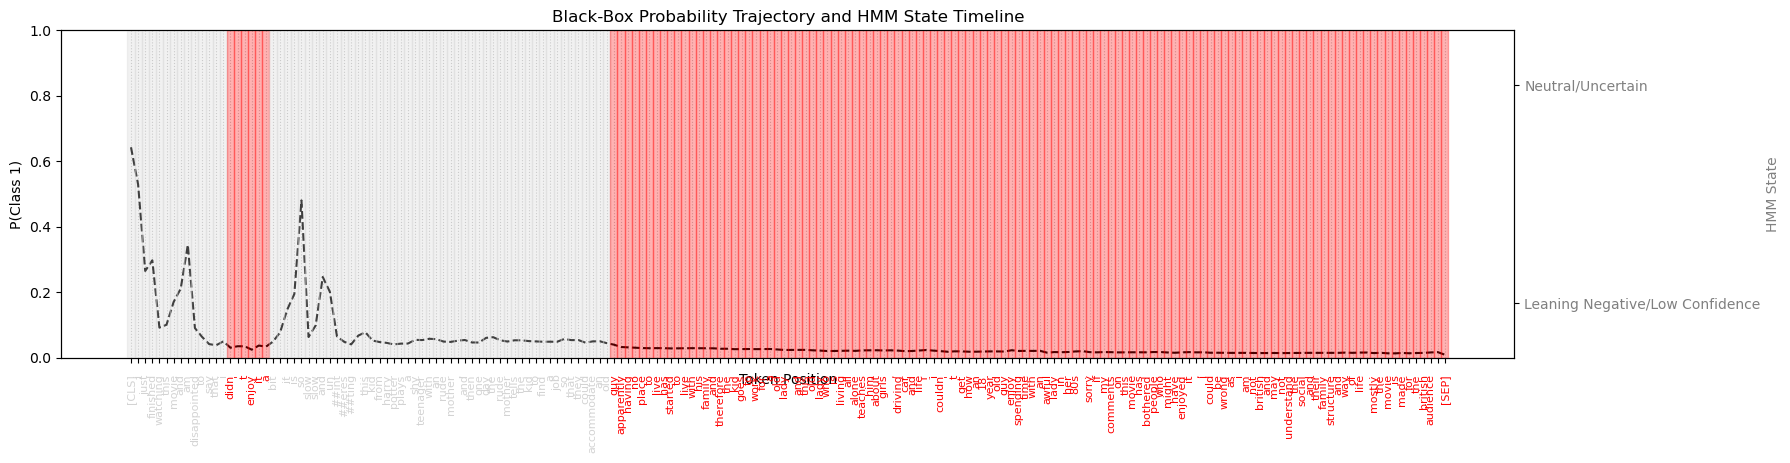

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 2:
Text: Blind Date (Columbia Pictures, 1934), was a decent film, but I have a few issues with this film. First of all, I don't fault the actors in this film at all, but more or less, I have a problem with the...

Sentence tokens with HMM colors:
[CLS] blind date ( columbia pictures , 1934 ) , was a decent film , but i have a few issues with this film . first of all , i don ' t fault the actors in this film at all , but more or less , i have a problem with the script . also , i understand that this film was made in the 1930 ' s and people were looking to escape reality , but the script made ann so ##ther ##n ' s character look weak . she kept going back and forth between suit ##ors and i felt as though she should have stayed with paul kelly ' s character in the end . he truly did care about her and her family and would have done anything for her and he did by 

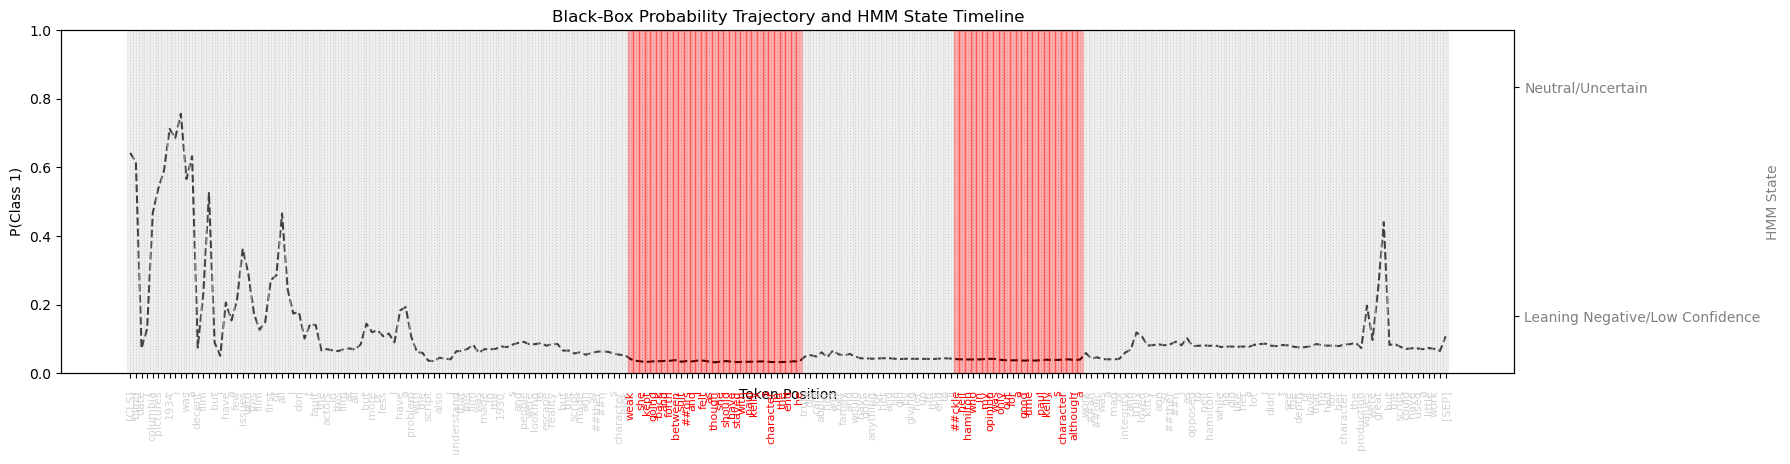

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 3:
Text: its a totally average film with a few semi-alright action sequences that make the plot seem a little better and remind the viewer of the classic van dam films. parts of the plot don't make sense and s...

Sentence tokens with HMM colors:
[CLS] its a totally average film with a few semi - alright action sequences that make the plot seem a little better and remind the viewer of the classic van dam films . parts of the plot don ' t make sense and seem to be added in to use up time . the end plot is that of a very basic type that doesn ' t leave the viewer guessing and any twists are obvious from the beginning . the end scene with the fl ##ask backs don ' t make sense as they are added in and seem to have little relevance to the history of van dam ' s character . not really worth watching again , bit disappointed in the end production , even though it is 

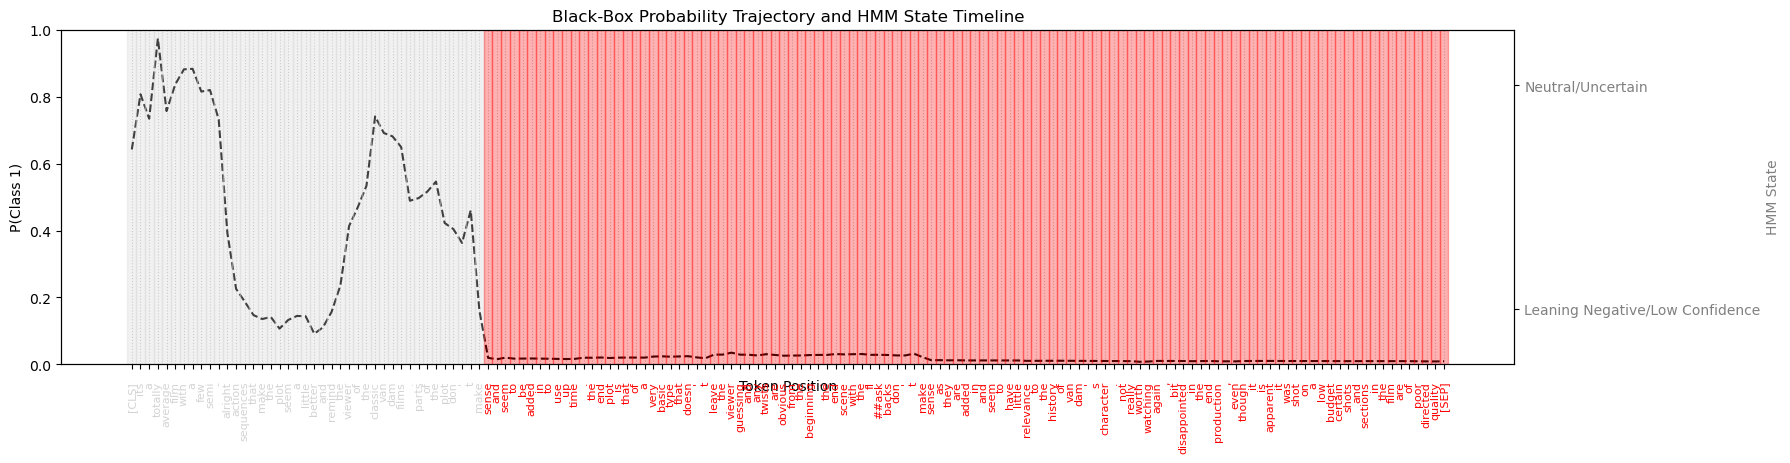

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 4:
Text: It actually pains me to say it, but this movie was horrible on every level. The blame does not lie entirely with Van Damme as you can see he tried his best, but let's face it, he's almost fifty, how m...

Sentence tokens with HMM colors:
[CLS] it actually pains me to say it , but this movie was horrible on every level . the blame does not lie entirely with van dam ##me as you can see he tried his best , but let ' s face it , he ' s almost fifty , how much more can you ask of him ? i find it so hard to believe that the same people who put together und ##is ##puted 2 ; arguably the best ( western ) martial arts movie in years , created this . everything from the plot , to the dial ##og , to the editing , to the overall acting was just horribly put together and in many cases outright boring and non ##sen ##sic ##al . scott ad ##kins who ' s fight scenes 

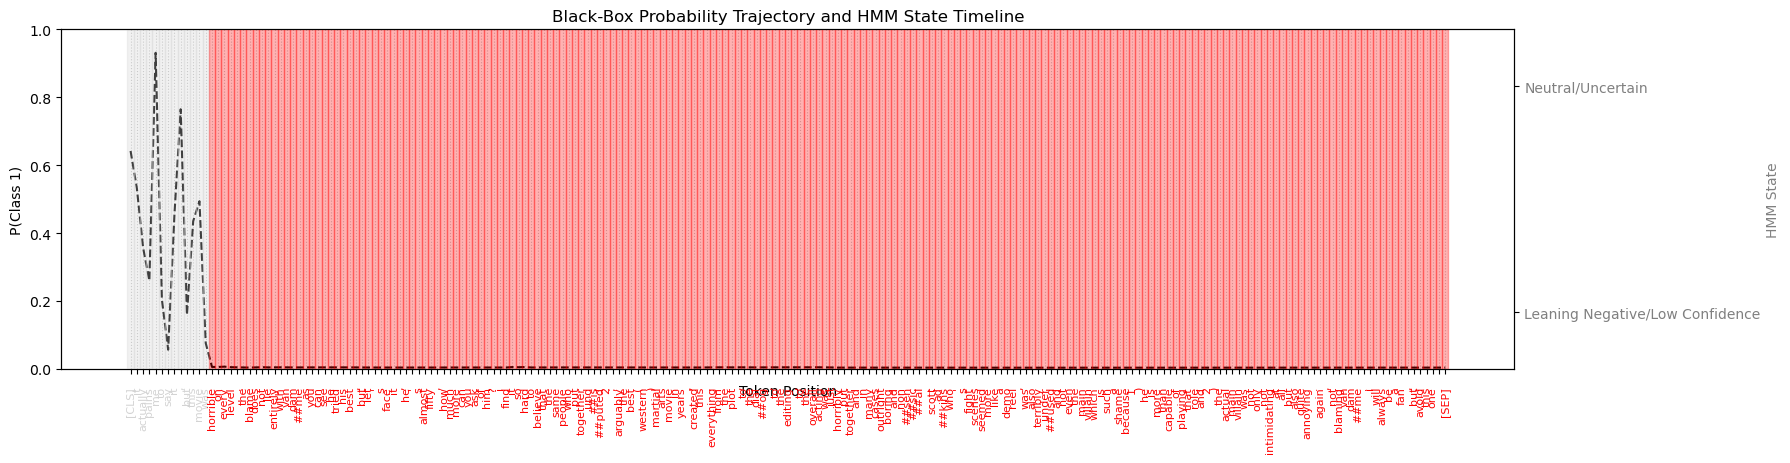

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 5:
Text: Now, I LOVE Italian horror films. The cheesier they are, the better. However, this is not cheesy Italian. This is week-old spaghetti sauce with rotting meatballs. It is amateur hour on every level. Th...

Sentence tokens with HMM colors:
[CLS] now , i love italian horror films . the che ##es ##ier they are , the better . however , this is not che ##es ##y italian . this is week - old spaghetti sauce with rotting meat ##balls . it is amateur hour on every level . there is no suspense , no horror , with just a few drops of blood scattered around to remind you that you are in fact watching a horror film . the " special effects " consist of the lights changing to red whenever the ghost ( or whatever it was supposed to be ) is around , and a string pulling bed sheets up and down . o ##oo ##h , can you feel the chill ##s ? the dvd quality is that of a vhs t

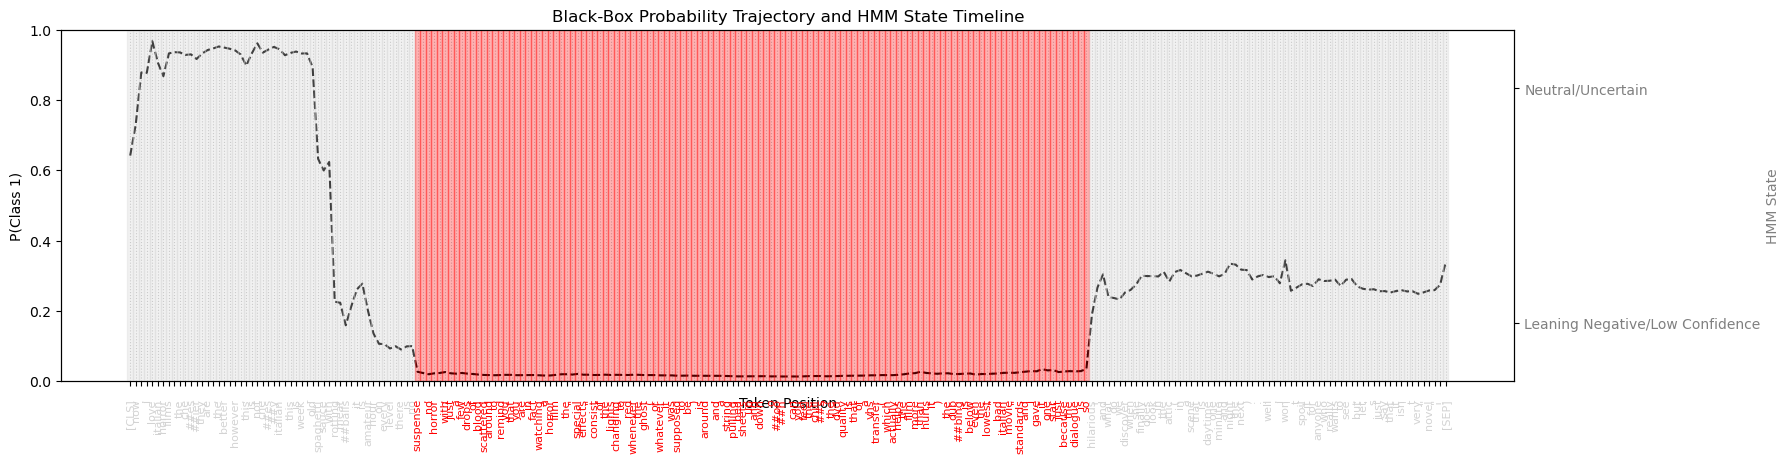

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 6:
Text: First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably will not like this movie. Most of these movies may not have the best plots or best actors but I enjoy thes...

Sentence tokens with HMM colors:
[CLS] first off let me say , if you haven ' t enjoyed a van dam ##me movie since blood ##sport , you probably will not like this movie . most of these movies may not have the best plots or best actors but i enjoy these kinds of movies for what they are . this movie is much better than any of the movies the other action guys ( sega ##l and do ##lp ##h ) have thought about putting out the past few years . van dam ##me is good in the movie , the movie is only worth watching to van dam ##me fans . it is not as good as wake of death ( which i highly recommend to anyone of likes van dam ##me ) or in hell but , in my opinion

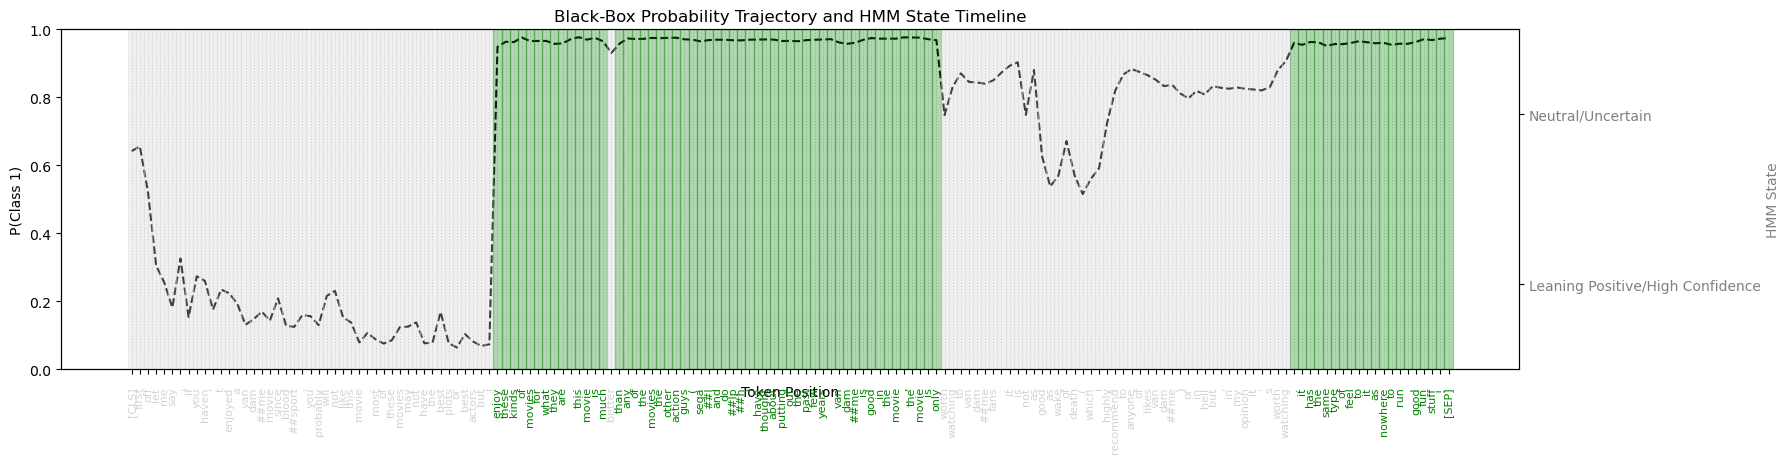

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 7:
Text: This cheap, grainy-filmed Italian flick is about a couple of inheritors of a manor in the Italian countryside who head up to the house to stay, and then find themselves getting killed off by ghosts of...

Sentence tokens with HMM colors:
[CLS] this cheap , grain ##y - filmed italian flick is about a couple of inherit ##ors of a manor in the italian countryside who head up to the house to stay , and then find themselves getting killed off by ghosts of people killed in that house . < br / > < br / > i wasn ' t impressed by this . it wasn ' t really that scary , mostly just the way a cheap italian film should be . a girl , her two cousins , and one cousin ' s girlfriend , head to this huge house for some reason ( i couldn ' t figure out why ) and are staying there , cleaning up and checking out the place . characters come in and out of the film , and it 

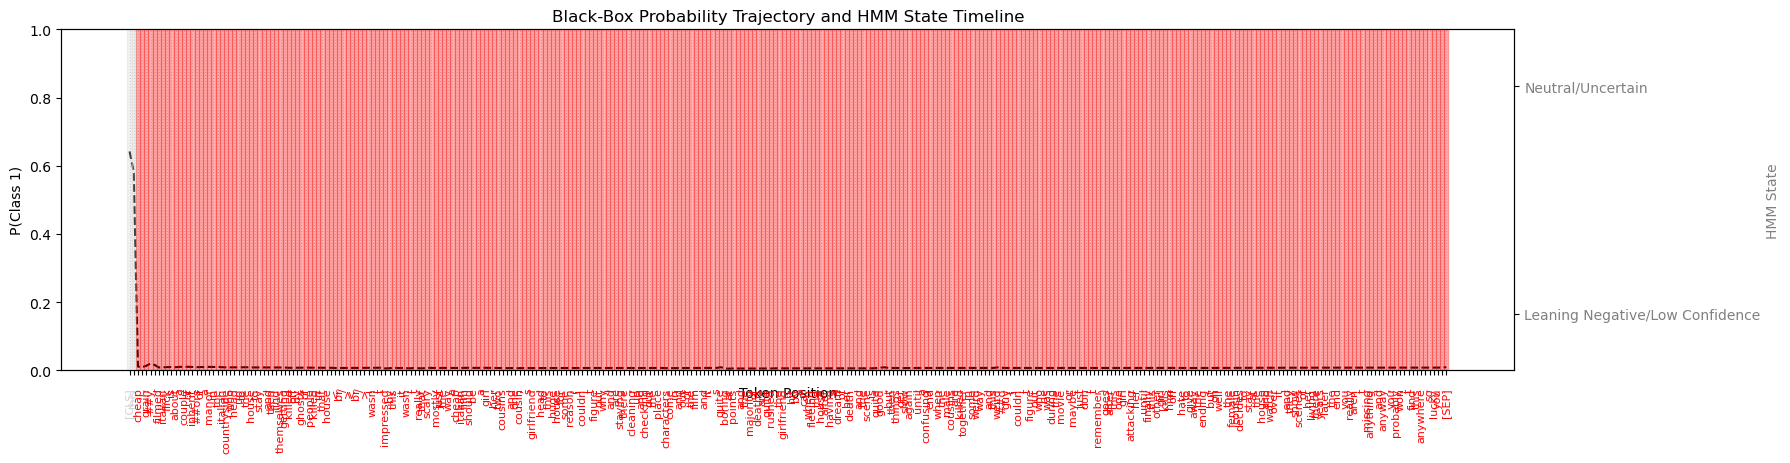

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 8:
Text: This flick is a waste of time.I expect from an action movie to have more than 2 explosions and some shooting.Van Damme's acting is awful. He never was much of an actor, but here it is worse.He was def...

Sentence tokens with HMM colors:
[CLS] this flick is a waste of time . i expect from an action movie to have more than 2 explosions and some shooting . van dam ##me ' s acting is awful . he never was much of an actor , but here it is worse . he was definitely better in his earlier movies . his screenplay part for the whole movie was probably not more than one page of stupid nonsense one liner ##s . the whole dial ##og in the film is a disaster , same as the plot . the title " the shepherd " makes no sense . why didn ' t they just call it " border patrol " ? the fighting scenes could have been better , but either they weren ' t able to afford it , or 

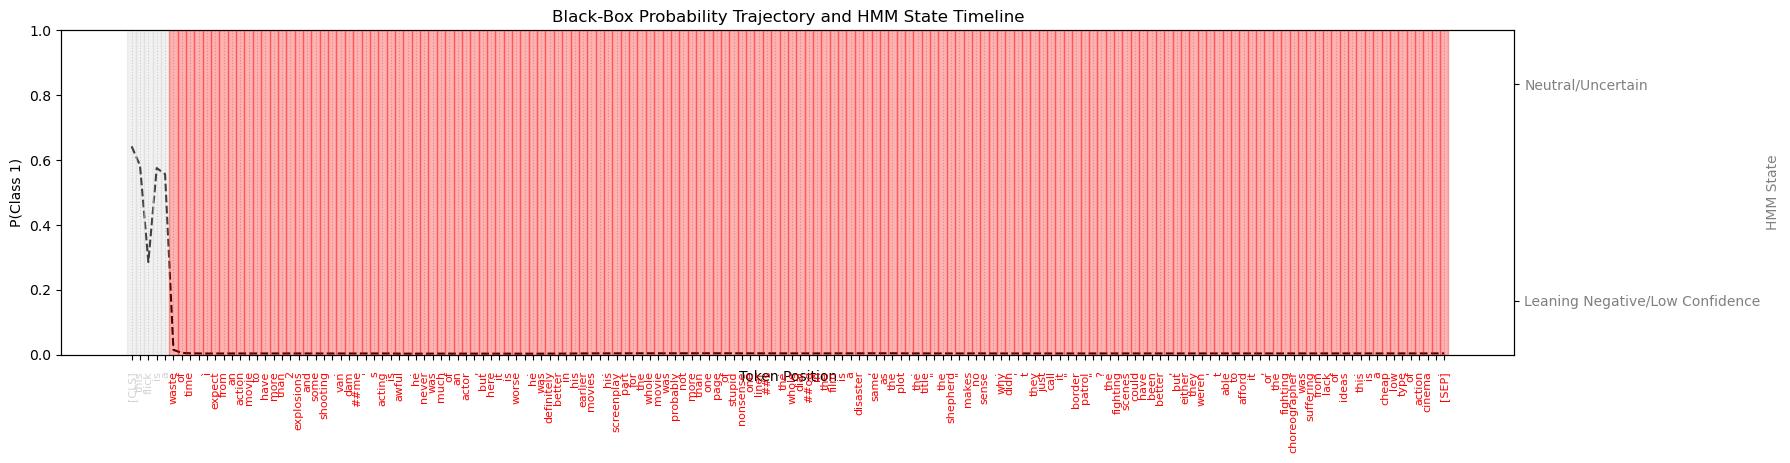

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 9:
Text: Technically I'am a Van Damme Fan, or I was. this movie is so bad that I hated myself for wasting those 90 minutes. Do not let the name Isaac Florentine (Undisputed II) fool you, I had big hopes for th...

Sentence tokens with HMM colors:
[CLS] technically i ' am a van dam ##me fan , or i was . this movie is so bad that i hated myself for wasting those 90 minutes . do not let the name isaac fl ##ore ##ntine ( und ##is ##puted ii ) fool you , i had big hopes for this one , depending on what i saw in ( und ##is ##puted ii ) , man . . was i wrong ? ? ! all action fans wanted a big comeback for the classic action hero , but i guess we won ##t be able to see that soon , as our hero keep coming with those ( going - to - a - border - far - away - town - and - kill - the - bad - guys - than - comeback - home ) movies i mean for god ' s sake , we are in 2008 , 

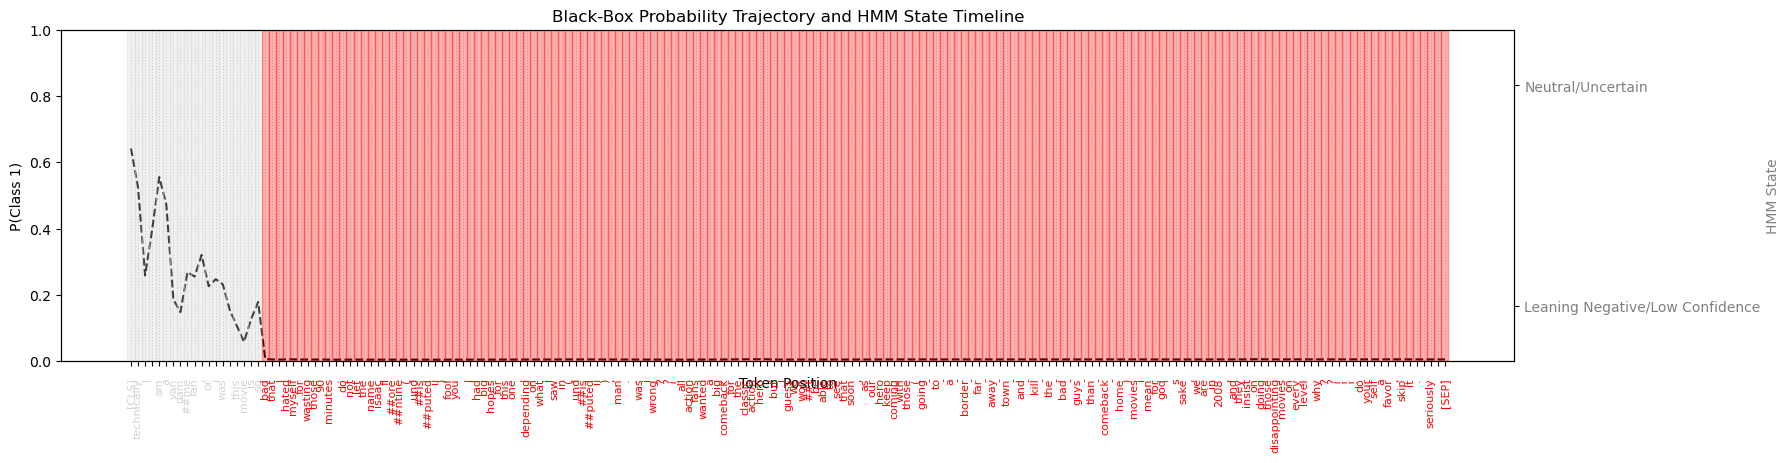

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 10:
Text: Every movie I have PPV'd because Leonard Maltin praised it to the skies has blown chunks! Every single one! When will I ever learn?<br /><br />Evie is a raving Old Bag who thinks nothing of saying she...

Sentence tokens with HMM colors:
[CLS] every movie i have pp ##v ' d because leonard mal ##tin praised it to the skies has blown chunks ! every single one ! when will i ever learn ? < br / > < br / > evie is a ravi ##ng old bag who thinks nothing of saying she ' s dying of breast cancer to get her way ! laura is an ins ##uf ##fera ##ble med ##usa filled with the holy spirit ( and her hub ##by ' s protege ) ! caught between these harp ##ies is med ##usa ' s dumb - as - a - rock boy who has been pressed into weed - pulling ser ##vi ##tu ##de by the old bag ! < br / > < br / > as i said , when will i ever learn ? < br / > < br / > i was temporarily lif

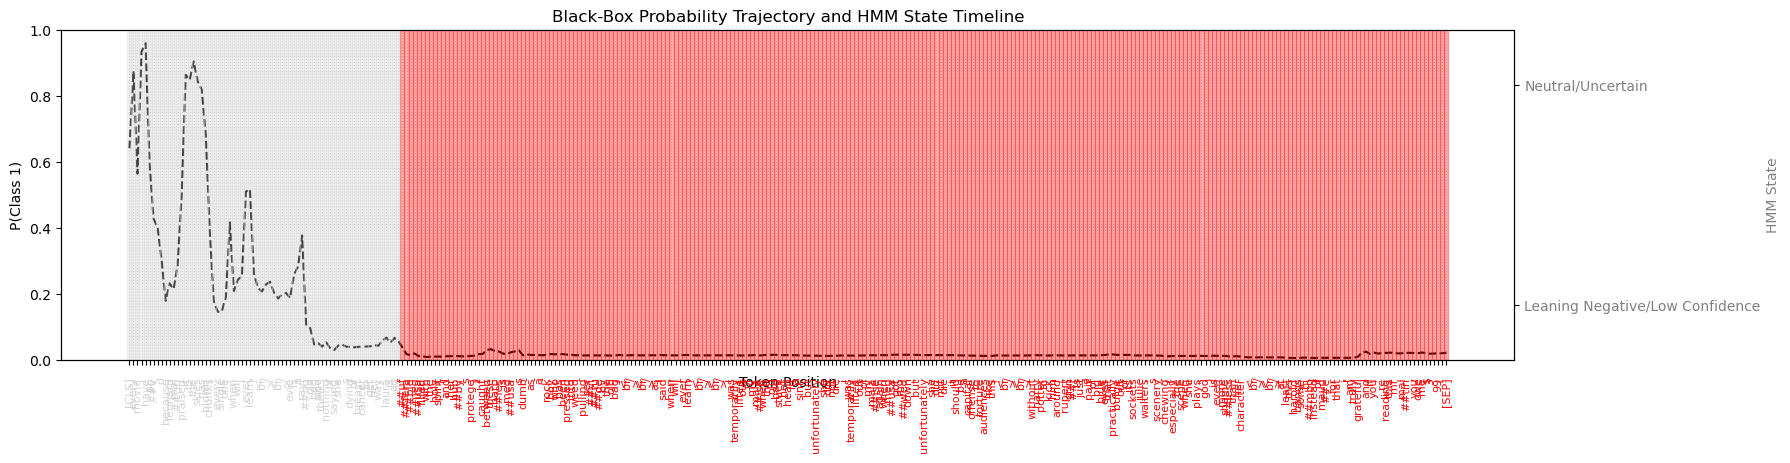

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 11:
Text: I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Bab...

Sentence tokens with HMM colors:
[CLS] i love sci - fi and am willing to put up with a lot . sci - fi movies / tv are usually under ##fu ##nded , under - appreciated and misunderstood . i tried to like this , i really did , but it is to good tv sci - fi as babylon 5 is to star trek ( the original ) . silly pro ##st ##hetic ##s , cheap cardboard sets , stil ##ted dialogues , c ##g that doesn ' t match the background , and painfully one - dimensional characters cannot be overcome with a ' sci - fi ' setting . ( i ' m sure there are those of you out there who think babylon 5 is good sci - fi tv . it ' s not . it ' s cl ##iche ##d and un ##ins ##pi ##ri

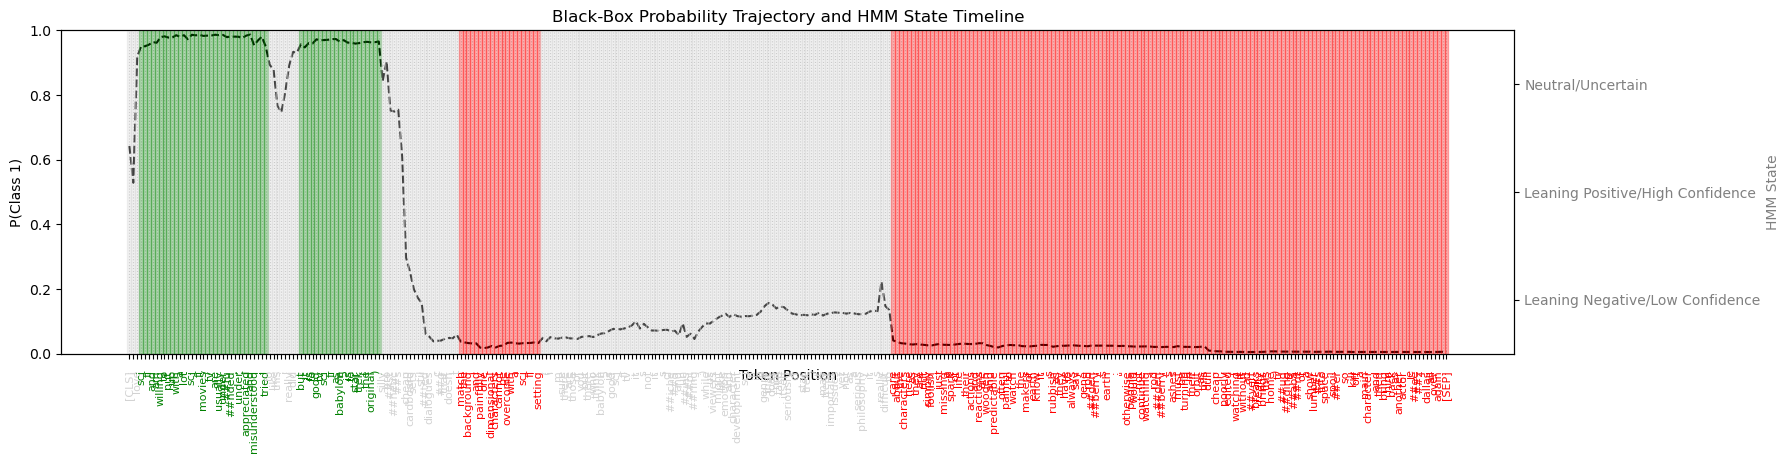

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 12:
Text: Ben, (Rupert Grint), is a deeply unhappy adolescent, the son of his unhappily married parents. His father, (Nicholas Farrell), is a vicar and his mother, (Laura Linney), is ... well, let's just say sh...

Sentence tokens with HMM colors:
[CLS] ben , ( rupert grin ##t ) , is a deeply unhappy adolescent , the son of his un ##ha ##pp ##ily married parents . his father , ( nicholas farrell ) , is a vicar and his mother , ( laura lin ##ney ) , is . . . well , let ' s just say she ' s a somewhat h ##yp ##oc ##rit ##ical soldier in jesus ' army . it ' s only when he takes a summer job as an assistant to a foul - mouthed , eccentric , once - famous and now - forgotten actress evie walton , ( julie walters ) , that he finally finds himself in true ' harold and maud ##e ' fashion . of course , evie is deeply unhappy herself and it ' s only when these two sad s

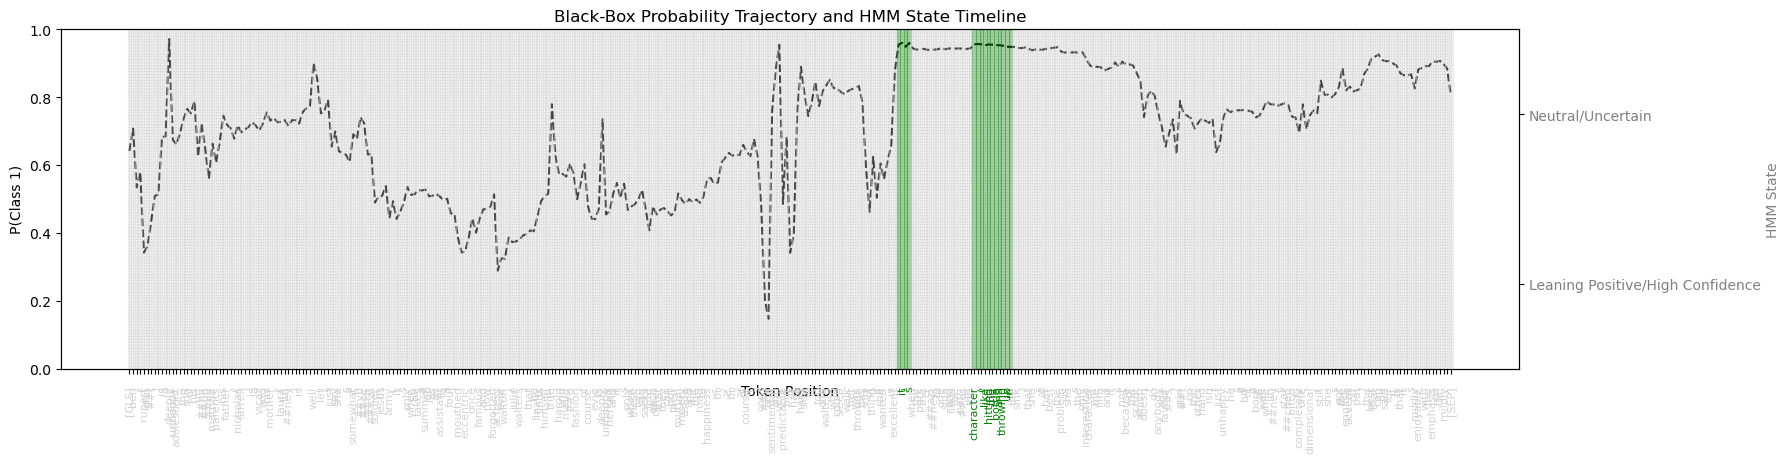

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 13:
Text: Honestly awful film, bad editing, awful lighting, dire dialog and scrappy screenplay.<br /><br />The lighting at is so bad there's moments you can't even see what's going on, I even tried to playing w...

Sentence tokens with HMM colors:
[CLS] honestly awful film , bad editing , awful lighting , dire dial ##og and scrap ##py screenplay . < br / > < br / > the lighting at is so bad there ' s moments you can ' t even see what ' s going on , i even tried to playing with the contrast and brightness so i could see something but that didn ' t help . < br / > < br / > they must have found the script in a bin , the character development is just as awful and while you hardly expect much from a jean - claude van dam ##me film this one manages to hit an all time low . you can ' t even laugh at the che ##es ##y ' ness . < br / > < br / > the directing and editin

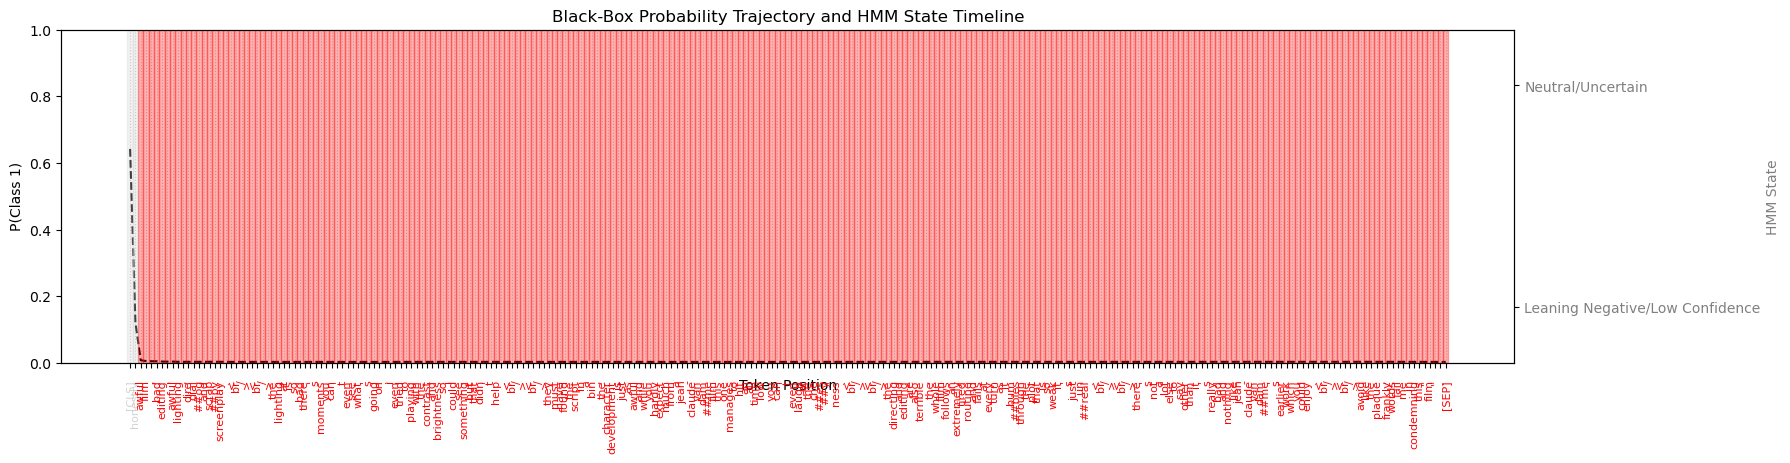

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 14:
Text: I first watched this movie back in the mid/late 80's, when I was a kid. We couldn't even get all the way through it. The dialog, the acting, everything about it was just beyond lame.<br /><br />Here a...

Sentence tokens with HMM colors:
[CLS] i first watched this movie back in the mid / late 80 ' s , when i was a kid . we couldn ' t even get all the way through it . the dial ##og , the acting , everything about it was just beyond lame . < br / > < br / > here are a few examples . . . imagine these spoken real dramatically , way over - acted : " ore ##ego ##n ? you ' re going to ore ##ego ##n ? why would anyone want to go to ore ##ego ##n ? " < br / > < br / > " survival ##ists ? nobody ever told us about any survival ##ists ! " < br / > < br / > this movie was so bad , my sister and i rented it again for her 16th birthday party , just so our friends

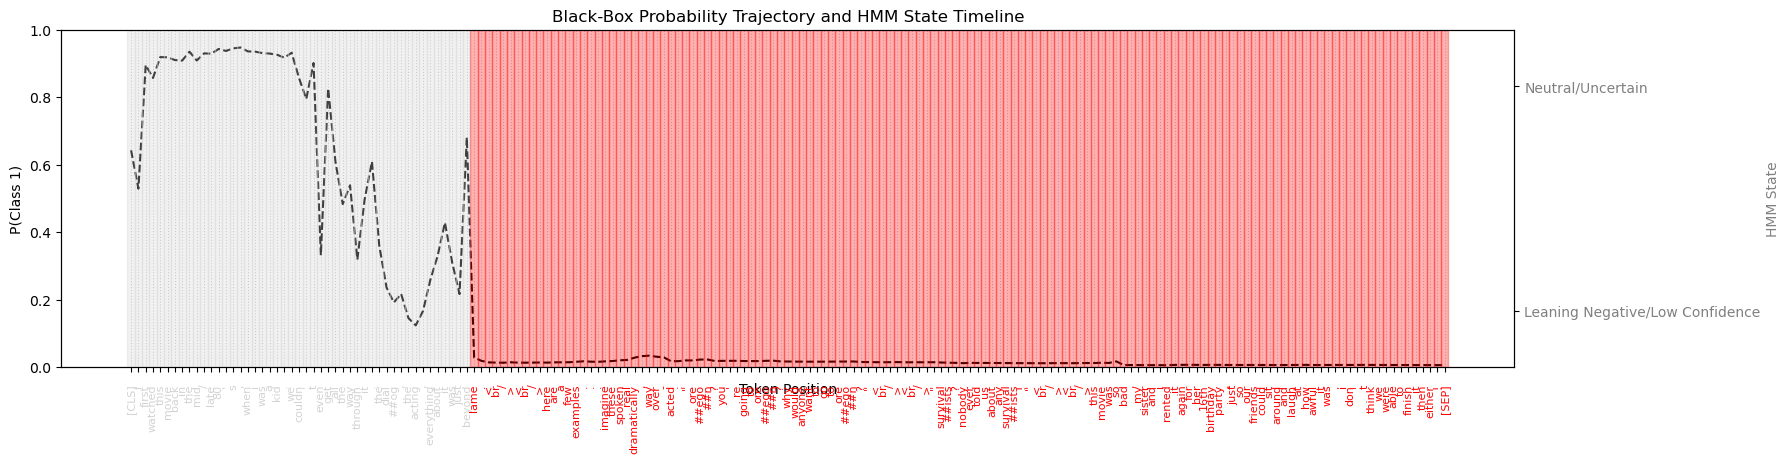

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 15:
Text: Isaac Florentine has made some of the best western Martial Arts action movies ever produced. In particular US Seals 2, Cold Harvest, Special Forces and Undisputed 2 are all action classics. You can te...

Sentence tokens with HMM colors:
[CLS] isaac fl ##ore ##ntine has made some of the best western martial arts action movies ever produced . in particular us seals 2 , cold harvest , special forces and und ##is ##puted 2 are all action classics . you can tell isaac has a real passion for the genre and his films are always event ##ful , creative and sharp affairs , with some of the best fight sequences an action fan could hope for . in particular he has found a muse with scott ad ##kins , as talented an actor and action performer as you could hope for . this is borne out with special forces and und ##is ##puted 2 , but unfortunately the shepherd just d

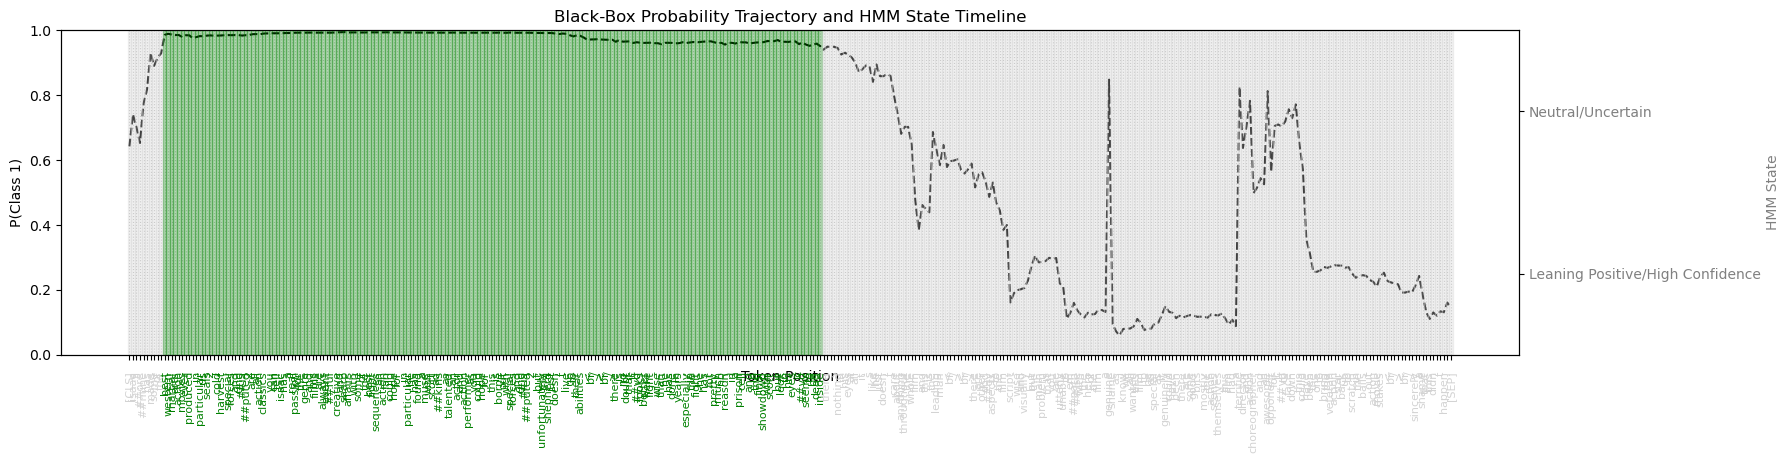

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 16:
Text: Worth the entertainment value of a rental, especially if you like action movies. This one features the usual car chases, fights with the great Van Damme kick style, shooting battles with the 40 shell ...

Sentence tokens with HMM colors:
[CLS] worth the entertainment value of a rental , especially if you like action movies . this one features the usual car chases , fights with the great van dam ##me kick style , shooting battles with the 40 shell load shotgun , and even terrorist style bombs . all of this is entertaining and competent ##ly handled but there is nothing that really blows you away if you ' ve seen your share before . < br / > < br / > the plot is made interesting by the inclusion of a rabbit , which is clever but hardly profound . many of the characters are heavily stereo ##type ##d - - the angry veterans , the terrified illegal aliens 

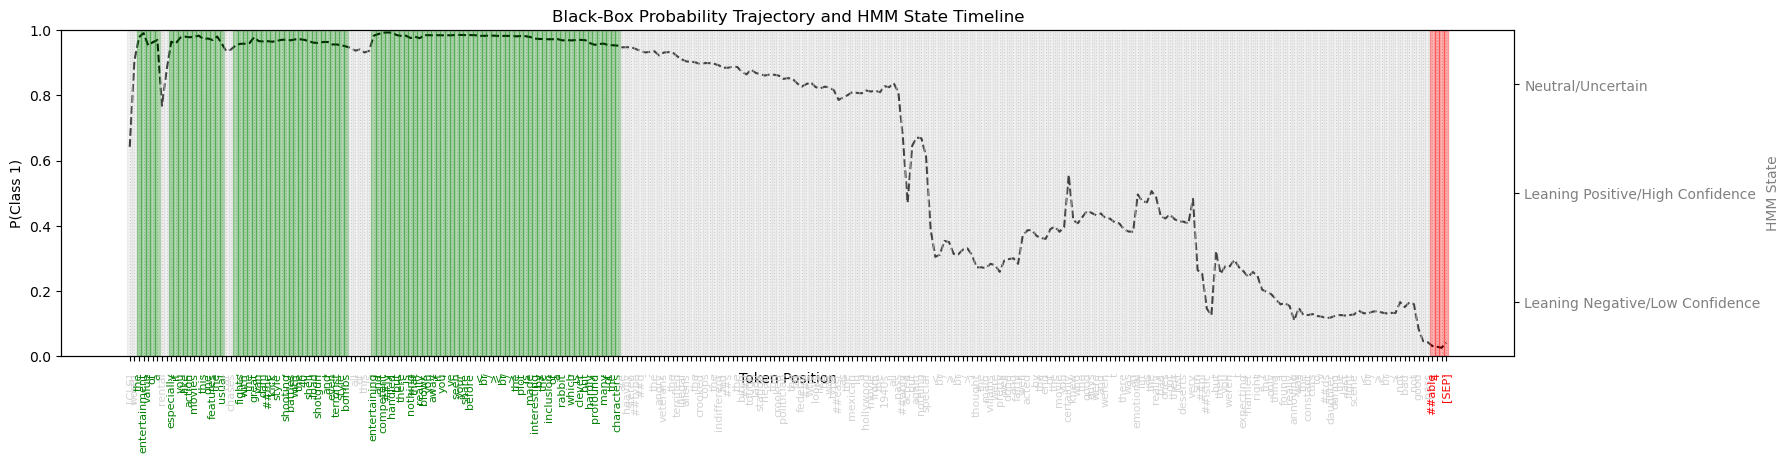

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 17:
Text: I had high hopes for this one until they changed the name to 'The Shepherd : Border Patrol, the lamest movie name ever, what was wrong with just 'The Shepherd'. This is a by the numbers action flick t...

Sentence tokens with HMM colors:
[CLS] i had high hopes for this one until they changed the name to ' the shepherd : border patrol , the lame ##st movie name ever , what was wrong with just ' the shepherd ' . this is a by the numbers action flick that tips its hat at many classic van dam ##me films . there is a nice bit of action in a bar which reminded me of hard target and universal soldier but directed with no intensity or flair which is a shame . there is one great line about ' being p * ss drunk and carrying a rabbit ' and some ok action scenes let down by the cheap ##ness of it all . a lot of the times the dialogue doesn ' t match the characte

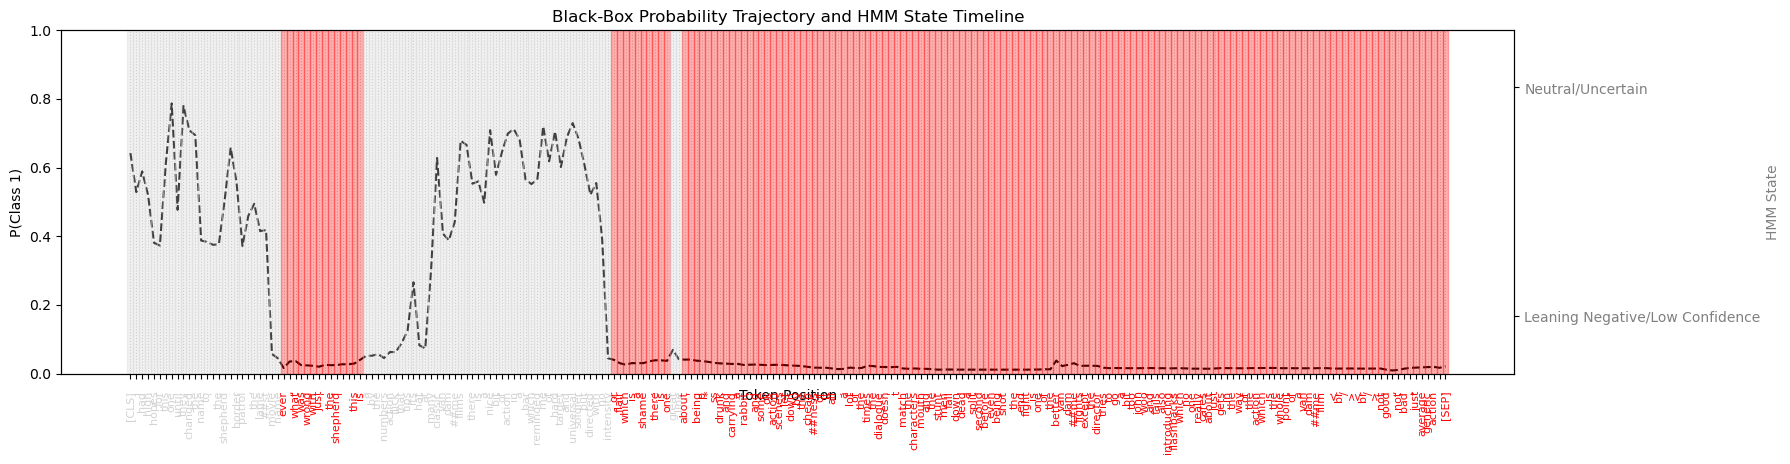

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 18:
Text: A group of heirs to a mysterious old mansion find out that they have to live in it as part of a clause in the will or be disinherited, but they soon find out of its history of everybody whom had lived...

Sentence tokens with HMM colors:
[CLS] a group of heirs to a mysterious old mansion find out that they have to live in it as part of a clause in the will or be di ##sin ##her ##ited , but they soon find out of its history of everybody whom had lived there before them having either died in weird accidents or having had killed each other . < br / > < br / > you ' ve seen it all before , and this one is too low - budget and slow paced to be scary , and doesn ' t have any real surprises in the climax . no special effects or gore to speak of , in fact the only really amusing thing about the whole film is the quality of the english dub ##bing , which at t

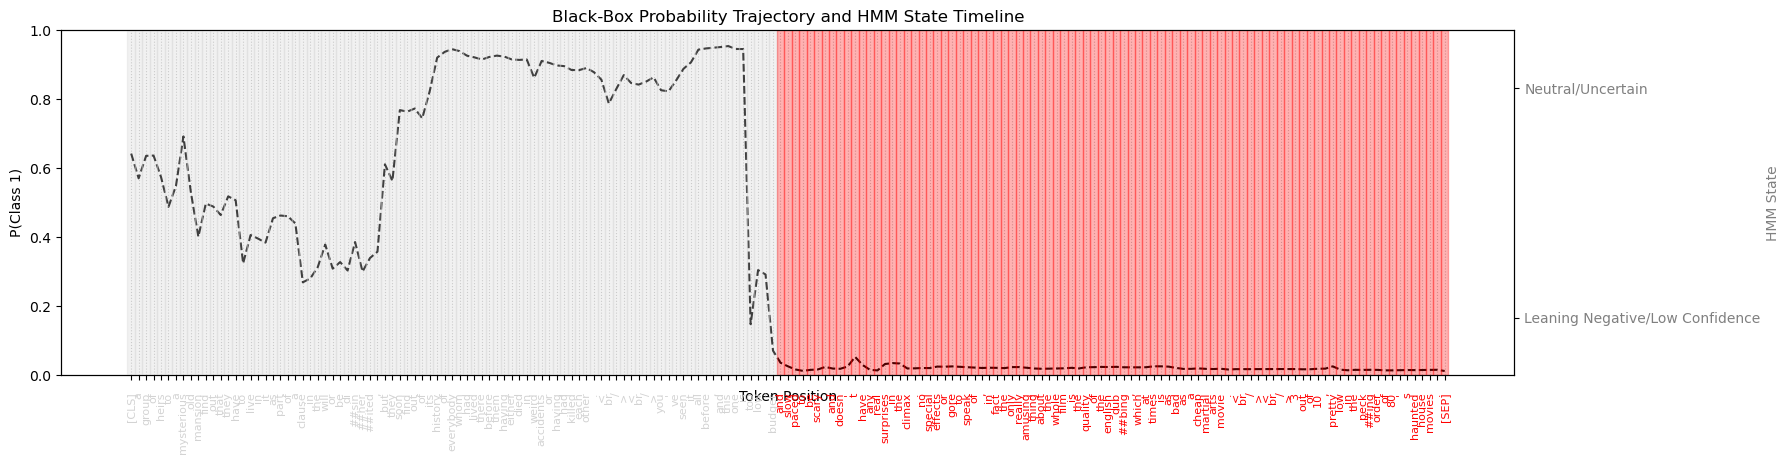

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 19:
Text: STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday Morning <br /><br />Former New Orleans homicide cop Jack Robideaux (Jean Claude Van Damme) is re-assigne...

Sentence tokens with HMM colors:
[CLS] star rating : * * * * * saturday night * * * * friday night * * * friday morning * * sunday night * monday morning < br / > < br / > former new orleans homicide cop jack rob ##ide ##aux ( jean claude van dam ##me ) is re - assigned to columbus , a small but violent town in mexico to help the police there with their efforts to stop a major heroin smuggling operation into their town . the cu ##lp ##rit ##s turn out to be ex - military , lead by former commander benjamin meyer ##s ( stephen lord , otherwise known as jase from east end ##ers ) who is using a special method he learned in afghanistan to fight off his

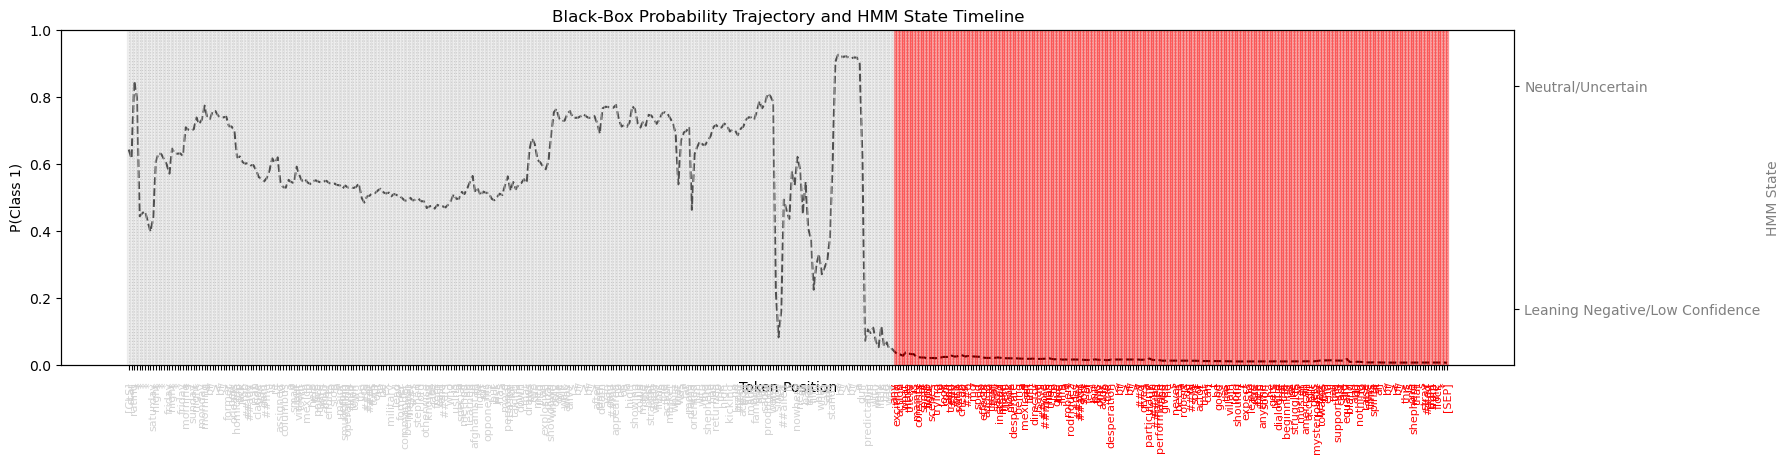

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl

Visualizing Test Sample 20:
Text: I saw the Mogul Video VHS of this. That's another one of those old 1980s distributors whose catalog I wish I had!<br /><br />This movie was pretty poor. Though retitled "Don't Look in the Attic," the ...

Sentence tokens with HMM colors:
[CLS] i saw the mo ##gul video vhs of this . that ' s another one of those old 1980s distributors whose catalog i wish i had ! < br / > < br / > this movie was pretty poor . though re ##titled " don ' t look in the attic , " the main ad ##mon ##ition that is repeated in this is " don ' t go to the villa . " just getting on the grounds of the villa is a bad idea . a character doesn ' t go into the attic until an hour into the movie , and actually should have done it earlier because of what is learned there . < br / > < br / > the movie starts in turin , italy in the 1950s . two men are fighting , and a woman is tellin

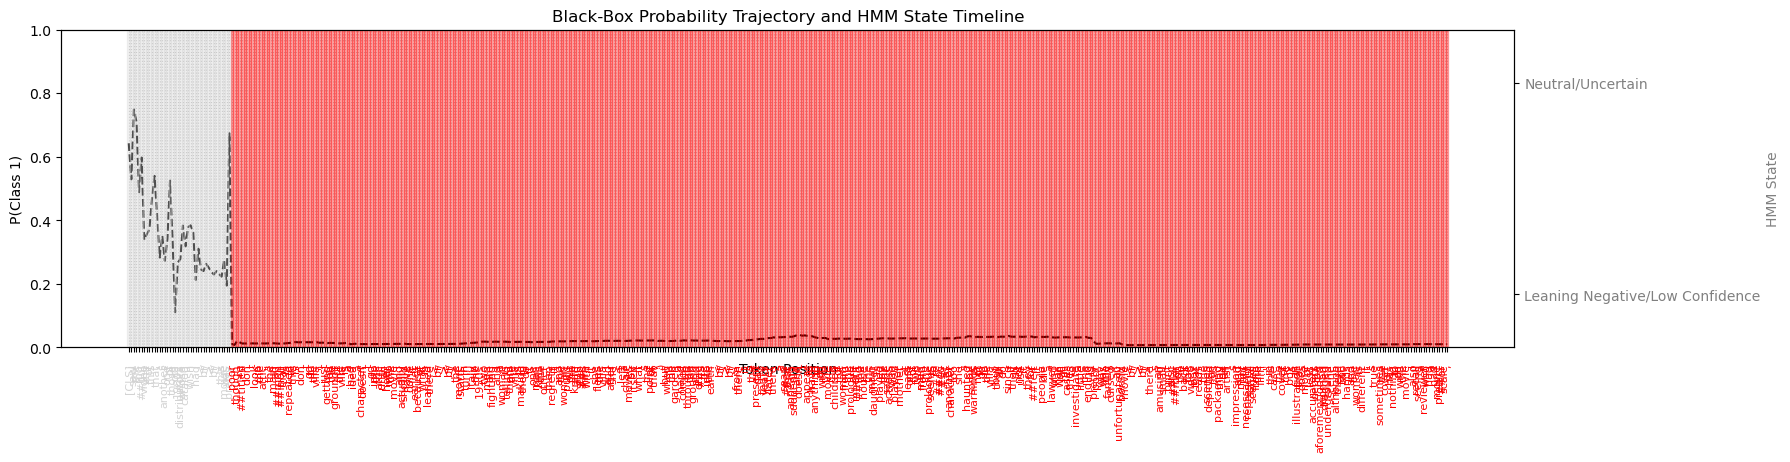

Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl


In [5]:
if hmm_surrogate_model and hmm_surrogate_model.is_trained and state_analysis_results:
    print("\n--- Visualizing HMM on Test Reviews ---")
    # Load black-box model for generating test trajectories
    bb_model_vis = BlackBoxSentimentClassifier(model_name=MODEL_NAME, device=DEVICE)
    tokenizer_vis = bb_model_vis.tokenizer

    # Load some test data
    imdb_test_raw = load_imdb_data(split='test', num_samples=NUM_TEST_SAMPLES, shuffle=True)
    processed_test_data = preprocess_data_for_inference_logging(imdb_test_raw, tokenizer_vis)

    # Get trajectories for test data
    test_trajectories_vis = log_inference_trajectories(processed_test_data, bb_model_vis, max_len=MAX_TOKENS)
    
    # Get the actual tokens for each processed test sample (up to MAX_TOKENS)
    test_tokens_vis = []
    for item in processed_test_data:
        # Ensure [CLS] is handled consistently if present
        cls_token_id = tokenizer_vis.cls_token_id
        actual_tokens = item['tokens']
        if cls_token_id is not None and item['input_ids'][0] == cls_token_id:
             # If CLS is already first, use tokens directly
             pass # actual_tokens = item['tokens']
        elif cls_token_id is not None:
             # Prepend [CLS] token string if model adds ID but it's not in original 'tokens'
             actual_tokens = [tokenizer_vis.cls_token] + item['tokens']
        
        test_tokens_vis.append(actual_tokens[:MAX_TOKENS])


    for i, (prob_traj, tokens) in enumerate(zip(test_trajectories_vis, test_tokens_vis)):
        if prob_traj.shape[0] == 0: continue # Skip empty trajectories

        decoded_states_vis = hmm_surrogate_model.decode_sequence(prob_traj)
        
        # Ensure token list length matches trajectory length for plotting
        # The trajectory length is min(len(original_tokens_with_cls), MAX_TOKENS)
        # The `tokens` list should be sliced to match this length.
        plot_tokens = tokens[:len(decoded_states_vis)]

        print(f"\nVisualizing Test Sample {i+1}:")
        print(f"Text: {processed_test_data[i]['text'][:200]}...")
        
        plt.figure(figsize=(18, 6))
        plot_state_timeline(
            plot_tokens,
            prob_traj,
            decoded_states_vis,
            state_names=state_analysis_results.get('state_names'),
            target_class_idx=TARGET_SENTIMENT,
            ax=plt.gca() # Pass current axes
        )
        plt.show()
        
        # save data for clustering
        np.save("data/clustering/test_trajectories_vis.npy", np.array(test_trajectories_vis, dtype=object))
        with open("data/clustering/test_tokens_vis.pkl", "wb") as f:
            pickle.dump(test_tokens_vis, f)
        with open("data/clustering/decoded_states_vis.pkl", "wb") as f:
            pickle.dump(decoded_states_vis, f)
        print("Saved items for clustering: test_trajectories_vis.npy, test_tokens_vis.pkl, and decoded_states_vis.pkl")
else:
    print("Skipping visualization as HMM model is not available or not trained, or state analysis is missing.")

In [ ]:

if hmm_surrogate_model and hmm_surrogate_model.is_trained:


    print("\n--- Calculating Fidelity on Loaded/Training Trajectories ---")
   
    if  test_trajectories_vis:
        # Let's take a subset for faster calculation if train_trajectories is very large
        num_fidelity_samples = len(test_trajectories_vis)
        fidelity_test_set = test_trajectories_vis[:num_fidelity_samples]
        
        fidelity_results = hmm_surrogate_model.calculate_fidelity_metrics(fidelity_test_set)
    
    else:
        print("No trajectories available to calculate fidelity.")
else:
    print("HMM model not trained or loaded. Skipping fidelity calculation.")


--- Baseline HMM Comparison ---

Training Dummy HMM with 3 states on 1000 trajectories...
Training HMM with 3 states on 1000 sequences.
Total observations: 276766, Observation dim: 2


         1 -373614.51828696             +nan
         2   23181.15359596 +396795.67188293
         3  460386.32568320 +437205.17208723
         4  675507.85200781 +215121.52632461
         5  784905.43012861 +109397.57812081
         6  849766.99110741  +64861.56097880
         7  900497.55786042  +50730.56675301
         8  931144.03331704  +30646.47545663
         9  951889.26858860  +20745.23527155
        10  965273.33822922  +13384.06964063
        11  973607.25733349   +8333.91910427
        12  978757.67258809   +5150.41525459
        13  982055.97959713   +3298.30700904
        14  984582.17465223   +2526.19505510
        15  986539.54936126   +1957.37470903
        16  987813.09811518   +1273.54875393
        17  988823.74351286   +1010.64539768
        18  989688.13556027    +864.39204741
        19  990268.73793958    +580.60237932
        20  990673.33908660    +404.60114701
        21  990979.95898998    +306.61990339
        22  991181.99268347    +202.03369349
        23

HMM training complete.

--- HMM Parameters ---
Initial state probabilities (startprob_):
 [0. 0. 1.]

Transition matrix (transmat_):
 [[9.94751492e-01 0.00000000e+00 5.24850782e-03]
 [1.28924913e-04 9.92906705e-01 6.96437011e-03]
 [8.95639249e-03 1.01275868e-02 9.80916021e-01]]

Emission probabilities (means_ for GaussianHMM):
 [[0.98683136 0.01316864]
 [0.0186903  0.9813097 ]
 [0.51832775 0.48167225]]

Emission covariances (covars_ for GaussianHMM):
 [[[9.24951403e-05 0.00000000e+00]
  [0.00000000e+00 9.24950856e-05]]

 [[2.31034439e-04 0.00000000e+00]
  [0.00000000e+00 2.31034505e-04]]

 [[1.07651114e-01 0.00000000e+00]
  [0.00000000e+00 1.07651114e-01]]]
Dummy HMM training complete.

--- Analyzing and Visualizing Dummy HMM Parameters ---

--- HMM State Analysis ---
State 0: Occurrences = 92466, Avg. P(Class 1) = 0.013
State 1: Occurrences = 85332, Avg. P(Class 1) = 0.981
State 2: Occurrences = 98968, Avg. P(Class 1) = 0.482

Suggested State Interpretations (based on P(Class {target_

<Figure size 800x600 with 0 Axes>

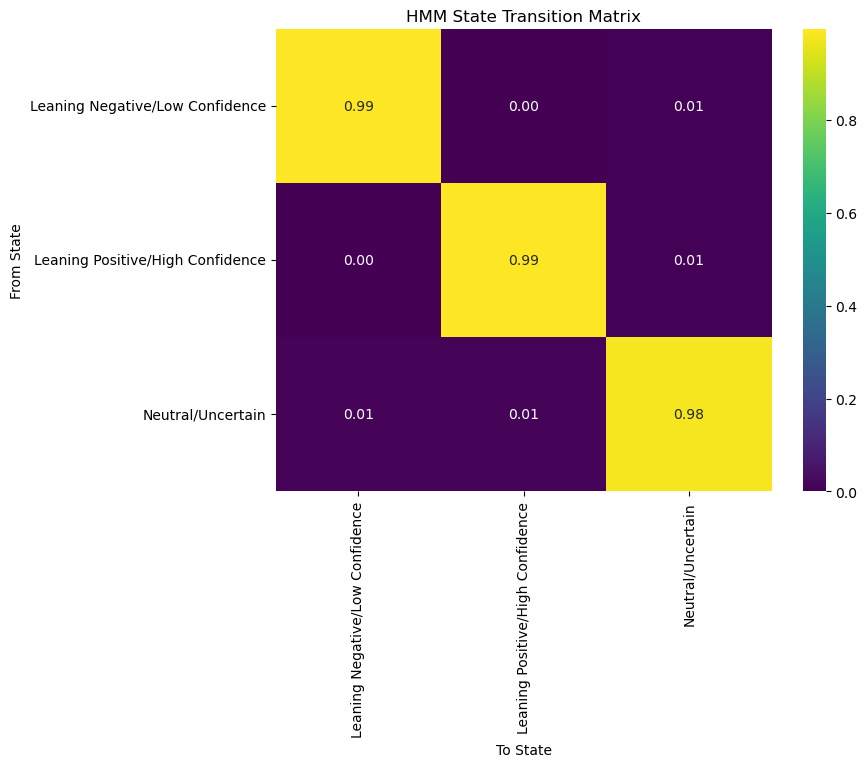


Dummy HMM Average Probabilities per State:


<Figure size 800x500 with 0 Axes>

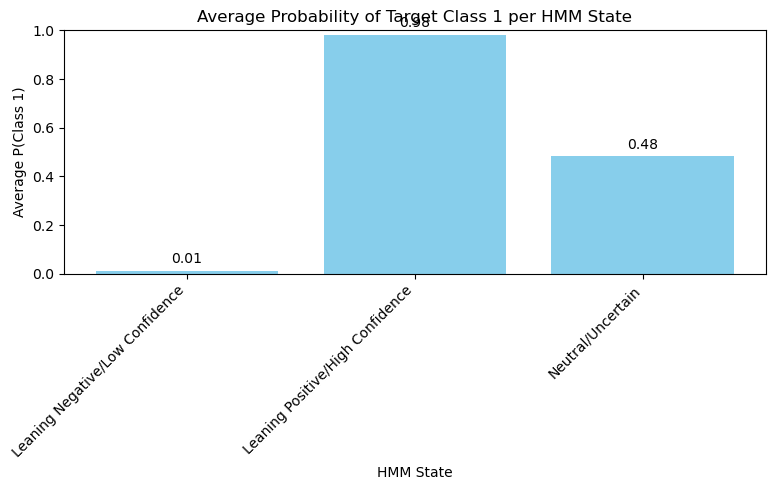


Preparing dedicated test set for fidelity evaluation using 20 samples from IMDB 'test' split...
Model loaded successfully on cuda
loaded black box model: lvwerra/distilbert-imdb
Labels: {0: 'NEGATIVE', 1: 'POSITIVE'}


Processing data: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]



Calculating Fidelity for Main HMM...
Calculating fidelity metrics...


100%|██████████| 20/20 [00:03<00:00,  6.57it/s]



--- Fidelity Metrics (5355 steps evaluated) ---
  Average KL Divergence (True BB || HMM Pred): 0.0820
     (Lower is better. 0 means perfect match in distribution.)
  Average Negative Log-Likelihood (NLL) / Cross-Entropy: 0.3045
     (Lower is better. Measures how 'surprising' the true observation is given HMM's prediction.)

Calculating Fidelity for Dummy HMM (trained on fewer samples)...
Calculating fidelity metrics...


100%|██████████| 20/20 [00:03<00:00,  6.63it/s]


--- Fidelity Metrics (5355 steps evaluated) ---
  Average KL Divergence (True BB || HMM Pred): 0.0751
     (Lower is better. 0 means perfect match in distribution.)
  Average Negative Log-Likelihood (NLL) / Cross-Entropy: 0.2976
     (Lower is better. Measures how 'surprising' the true observation is given HMM's prediction.)


--- Fidelity Comparison Summary ---

Main HMM (trained on full training data):
  Avg KL Divergence: 0.0820
  Avg NLL:           0.3045
  Steps Evaluated:   5355

Dummy HMM (trained on 1000 training samples):
  Avg KL Divergence: 0.0751
  Avg NLL:           0.2976
  Steps Evaluated:   5355

Comparison Insights:
  - Main HMM has HIGHER (worse) KL Divergence compared to Dummy HMM, or one/both is NaN/Inf.
  - Main HMM has HIGHER (worse) NLL compared to Dummy HMM, or one/both is NaN/Inf.
  (Lower KL and NLL values indicate a more faithful surrogate model.)


In [6]:

print("\n--- Baseline HMM Comparison ---")


NUM_TRAIN_SAMPLES_FOR_DUMMY_HMM = 1000
DUMMY_HMM_N_STATES = hmm_surrogate_model.n_states if hmm_surrogate_model and hmm_surrogate_model.is_trained else 4 # Use same states as main or default
DUMMY_HMM_N_ITER = 75
DUMMY_HMM_RANDOM_STATE = 2

dummy_hmm_model = None
dummy_train_set = [] 

if 'train_trajectories' in locals() and train_trajectories and len(train_trajectories) >= NUM_TRAIN_SAMPLES_FOR_DUMMY_HMM:
    print(f"\nTraining Dummy HMM with {DUMMY_HMM_N_STATES} states on {NUM_TRAIN_SAMPLES_FOR_DUMMY_HMM} trajectories...")
    dummy_train_set = train_trajectories[:NUM_TRAIN_SAMPLES_FOR_DUMMY_HMM]

    try:
        dummy_hmm_model = HMMSurrogate(
            n_states=DUMMY_HMM_N_STATES,
            n_iter=DUMMY_HMM_N_ITER,
            random_state=DUMMY_HMM_RANDOM_STATE,
            covariance_type='diag' 
        )
        dummy_hmm_model.train(dummy_train_set)
        print("Dummy HMM training complete.")
    except ValueError as e:
        print(f"Error training Dummy HMM: {e}")
        print("This can happen if covariance matrices are not positive-definite, often due to insufficient data for 'full' covariance.")
        print("Consider using 'diag' or 'spherical' covariance_type, or increasing NUM_TRAIN_SAMPLES_FOR_DUMMY_HMM if using 'full'.")
        dummy_hmm_model = None # Ensure model is None if training failed
    except Exception as e: # Catch any other unexpected errors during dummy HMM training
        print(f"An unexpected error occurred during Dummy HMM training: {e}")
        dummy_hmm_model = None

else:
    print(f"Not enough training trajectories ({len(train_trajectories) if 'train_trajectories' in locals() else 0}) to train dummy HMM with {NUM_TRAIN_SAMPLES_FOR_DUMMY_HMM} samples.")

dummy_state_analysis_results = None 
if dummy_hmm_model and dummy_hmm_model.is_trained:
    print("\n--- Analyzing and Visualizing Dummy HMM Parameters ---")
    if dummy_train_set: # Check if dummy_train_set was populated
        # Decode states for the dummy_train_set using the dummy_hmm_model
        dummy_decoded_train_states = [dummy_hmm_model.decode_sequence(traj) for traj in dummy_train_set if traj.shape[0] > 0]
        
        # Filter out empty sequences from dummy_train_set if their decoded_states are empty
        valid_dummy_train_trajectories = [traj for traj, states in zip(dummy_train_set, dummy_decoded_train_states) if states.size > 0]
        valid_dummy_decoded_train_states = [states for states in dummy_decoded_train_states if states.size > 0]

        if valid_dummy_train_trajectories and valid_dummy_decoded_train_states:
            dummy_state_analysis_results = dummy_hmm_model.analyze_states(
                valid_dummy_train_trajectories, 
                valid_dummy_decoded_train_states, 
                target_class_idx=TARGET_SENTIMENT
            )
            
            # Visualize Dummy HMM parameters
            print("\nDummy HMM Transition Matrix:")
            plt.figure(figsize=(8, 6))
            plot_hmm_transition_matrix(dummy_hmm_model.model, state_names=dummy_state_analysis_results.get('state_names'))
           
           

            print("\nDummy HMM Average Probabilities per State:")
            plt.figure(figsize=(8, 5))
            plot_avg_probabilities_per_state(dummy_state_analysis_results, target_class_idx=TARGET_SENTIMENT)
            
        else:
            print("No valid trajectories/states for Dummy HMM analysis after decoding its training set.")
    else:
        print("Dummy HMM was trained, but its training set (dummy_train_set) is empty or was not populated.")
else:
    print("Skipping Dummy HMM analysis and visualization as it was not trained successfully or is not defined.")


# --- 3. Prepare Dedicated Test Set for Fidelity Evaluation ---
fidelity_evaluation_set = []
print(f"\nPreparing dedicated test set for fidelity evaluation using {NUM_TEST_SAMPLES} samples from IMDB 'test' split...")



bb_model_for_fidelity_test = BlackBoxSentimentClassifier(model_name=MODEL_NAME, device=DEVICE)
tokenizer_for_fidelity_test = bb_model_for_fidelity_test.tokenizer

imdb_fidelity_test_raw = load_imdb_data(split='test', num_samples=NUM_TEST_SAMPLES, shuffle=True) 
processed_fidelity_test_data = preprocess_data_for_inference_logging(imdb_fidelity_test_raw, tokenizer_for_fidelity_test)
fidelity_evaluation_set = log_inference_trajectories(processed_fidelity_test_data, bb_model_for_fidelity_test, max_len=MAX_TOKENS)

# Filter out any potentially empty trajectories from the test set
fidelity_evaluation_set = [t for t in fidelity_evaluation_set if t.shape[0] > 0]





main_hmm_fidelity_results = None
if hmm_surrogate_model and hmm_surrogate_model.is_trained and fidelity_evaluation_set:
    print("\nCalculating Fidelity for Main HMM...")
    try:
        main_hmm_fidelity_results = hmm_surrogate_model.calculate_fidelity_metrics(fidelity_evaluation_set)
    except Exception as e:
        print(f"Error calculating fidelity for Main HMM: {e}")
else:
    print("Main HMM not ready or no evaluation set for fidelity.")


dummy_hmm_fidelity_results = None
if dummy_hmm_model and dummy_hmm_model.is_trained and fidelity_evaluation_set:
    print("\nCalculating Fidelity for Dummy HMM (trained on fewer samples)...") 
    try:
        dummy_hmm_fidelity_results = dummy_hmm_model.calculate_fidelity_metrics(fidelity_evaluation_set)
    except Exception as e:
        print(f"Error calculating fidelity for Dummy HMM: {e}")
else:
    print("Dummy HMM not ready or no evaluation set for fidelity.")


print("\n\n--- Fidelity Comparison Summary ---")

if main_hmm_fidelity_results:
    print(f"\nMain HMM (trained on full training data):")
    print(f"  Avg KL Divergence: {main_hmm_fidelity_results.get('avg_kl_divergence', float('nan')):.4f}")
    print(f"  Avg NLL:           {main_hmm_fidelity_results.get('avg_nll', float('nan')):.4f}")
    print(f"  Steps Evaluated:   {main_hmm_fidelity_results.get('total_steps_evaluated', 0)}")
else:
    print("\nMain HMM: Fidelity results not available.")

if dummy_hmm_fidelity_results:
    print(f"\nDummy HMM (trained on {NUM_TRAIN_SAMPLES_FOR_DUMMY_HMM} training samples):")
    print(f"  Avg KL Divergence: {dummy_hmm_fidelity_results.get('avg_kl_divergence', float('nan')):.4f}")
    print(f"  Avg NLL:           {dummy_hmm_fidelity_results.get('avg_nll', float('nan')):.4f}")
    print(f"  Steps Evaluated:   {dummy_hmm_fidelity_results.get('total_steps_evaluated', 0)}")
else:
    print("\nDummy HMM: Fidelity results not available.")

if main_hmm_fidelity_results and dummy_hmm_fidelity_results:
    print("\nComparison Insights:")
    # Ensure values are not NaN before comparison to avoid runtime warnings/errors
    main_kl = main_hmm_fidelity_results.get('avg_kl_divergence', float('inf'))
    dummy_kl = dummy_hmm_fidelity_results.get('avg_kl_divergence', float('inf'))
    main_nll = main_hmm_fidelity_results.get('avg_nll', float('inf'))
    dummy_nll = dummy_hmm_fidelity_results.get('avg_nll', float('inf'))

    # Handle potential NaN values from failed calculations gracefully
    main_kl = float('inf') if np.isnan(main_kl) else main_kl
    dummy_kl = float('inf') if np.isnan(dummy_kl) else dummy_kl
    main_nll = float('inf') if np.isnan(main_nll) else main_nll
    dummy_nll = float('inf') if np.isnan(dummy_nll) else dummy_nll

    if main_kl < dummy_kl:
        print("  - Main HMM has LOWER (better) KL Divergence than Dummy HMM.")
    elif main_kl == dummy_kl and main_kl != float('inf'):
        print("  - Main HMM has EQUAL KL Divergence as Dummy HMM.")
    elif main_kl == float('inf') and dummy_kl == float('inf'):
        print("  - KL Divergence for both Main and Dummy HMM is NaN/Inf.")
    else: # main_kl > dummy_kl or one is inf
        print("  - Main HMM has HIGHER (worse) KL Divergence compared to Dummy HMM, or one/both is NaN/Inf.")

    if main_nll < dummy_nll:
        print("  - Main HMM has LOWER (better) NLL than Dummy HMM.")
    elif main_nll == dummy_nll and main_nll != float('inf'):
        print("  - Main HMM has EQUAL NLL as Dummy HMM.")
    elif main_nll == float('inf') and dummy_nll == float('inf'):
        print("  - NLL for both Main and Dummy HMM is NaN/Inf.")
    else:
        print("  - Main HMM has HIGHER (worse) NLL compared to Dummy HMM, or one/both is NaN/Inf.")
    print("  (Lower KL and NLL values indicate a more faithful surrogate model.)")

DETAILED FIDELITY ANALYSIS WITH PREDICTION DISAGREEMENT PATTERNS

Comparing Main HMM (25k samples) vs Dummy HMM (1000 samples)
Test set: 20 sequences

=== Comparing Main-HMM (25k) vs Dummy-HMM (1000k) ===
Calculating detailed fidelity metrics...


100%|██████████| 20/20 [00:03<00:00,  6.50it/s]



--- Detailed Fidelity Analysis (5355 steps evaluated) ---

True Confident Negative:
  Count: 3597
  KL Divergence - Mean: 0.0705, Std: 0.1515, Median: 0.0037
  NLL - Mean: 0.1838, Std: 0.2437, Median: 0.0770

True Neutral:
  Count: 873
  KL Divergence - Mean: 0.0477, Std: 0.0479, Median: 0.0307
  NLL - Mean: 0.6939, Std: 0.0170, Median: 0.6929

True Confident Positive:
  Count: 885
  KL Divergence - Mean: 0.1626, Std: 0.1724, Median: 0.1315
  NLL - Mean: 0.4110, Std: 0.2802, Median: 0.6045

Overall:
  KL Divergence - Mean: 0.0820, Std: 0.1485
  NLL - Mean: 0.3045, Std: 0.2988

--------------------------------------------------
Calculating detailed fidelity metrics...


100%|██████████| 20/20 [00:03<00:00,  6.58it/s]



--- Detailed Fidelity Analysis (5355 steps evaluated) ---

True Confident Negative:
  Count: 3597
  KL Divergence - Mean: 0.0638, Std: 0.1438, Median: 0.0037
  NLL - Mean: 0.1771, Std: 0.2343, Median: 0.0770

True Neutral:
  Count: 873
  KL Divergence - Mean: 0.0497, Std: 0.0505, Median: 0.0332
  NLL - Mean: 0.6958, Std: 0.0240, Median: 0.6947

True Confident Positive:
  Count: 885
  KL Divergence - Mean: 0.1459, Std: 0.1717, Median: 0.0168
  NLL - Mean: 0.3943, Std: 0.2902, Median: 0.2326

Overall:
  KL Divergence - Mean: 0.0751, Std: 0.1421
  NLL - Mean: 0.2976, Std: 0.2967

=== COMPARISON SUMMARY ===
Format: Main-HMM (25k) vs Dummy-HMM (1000k)

True Confident Negative:
  Main-HMM (25k): 0.0705 ± 0.1515 (n=3597)
  Dummy-HMM (1000k): 0.0638 ± 0.1438 (n=3597)
  Winner: Dummy-HMM (1000k) (lower KL by 0.0067)

True Neutral:
  Main-HMM (25k): 0.0477 ± 0.0479 (n=873)
  Dummy-HMM (1000k): 0.0497 ± 0.0505 (n=873)
  Winner: Main-HMM (25k) (lower KL by 0.0019)

True Confident Positive:
  Main

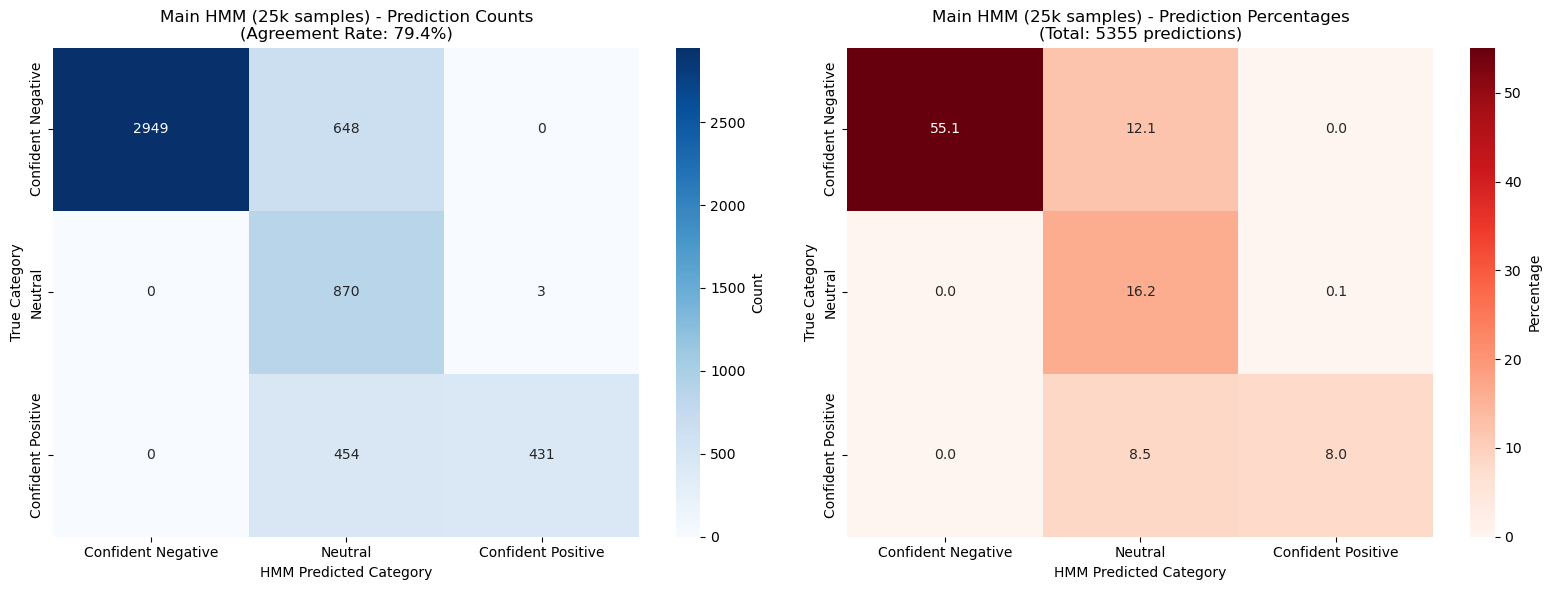


Analyzing Dummy HMM disagreement patterns...

=== PREDICTION DISAGREEMENT ANALYSIS ===
Analyzing 5355 predictions...
Total disagreements: 1038/5355 (19.4%)
Agreement rate: 80.6%

DISAGREEMENT BREAKDOWN:

Most common disagreement patterns:
  Confident Negative → Neutral: 642 cases (61.8% of disagreements), Avg KL: 0.337
  Confident Positive → Neutral: 391 cases (37.7% of disagreements), Avg KL: 0.319
  Neutral → Confident Positive: 4 cases (0.4% of disagreements), Avg KL: 0.370
  Confident Negative → Confident Positive: 1 cases (0.1% of disagreements), Avg KL: 2.817

High-severity disagreements (KL > 1.0): 1/1038
High-severity disagreement patterns:
  Confident Negative → Confident Positive: 1 cases

CATEGORY-SPECIFIC PERFORMANCE:
  Confident Negative: 2954/3597 correct (82.1%)
  Neutral: 869/873 correct (99.5%)
  Confident Positive: 494/885 correct (55.8%)


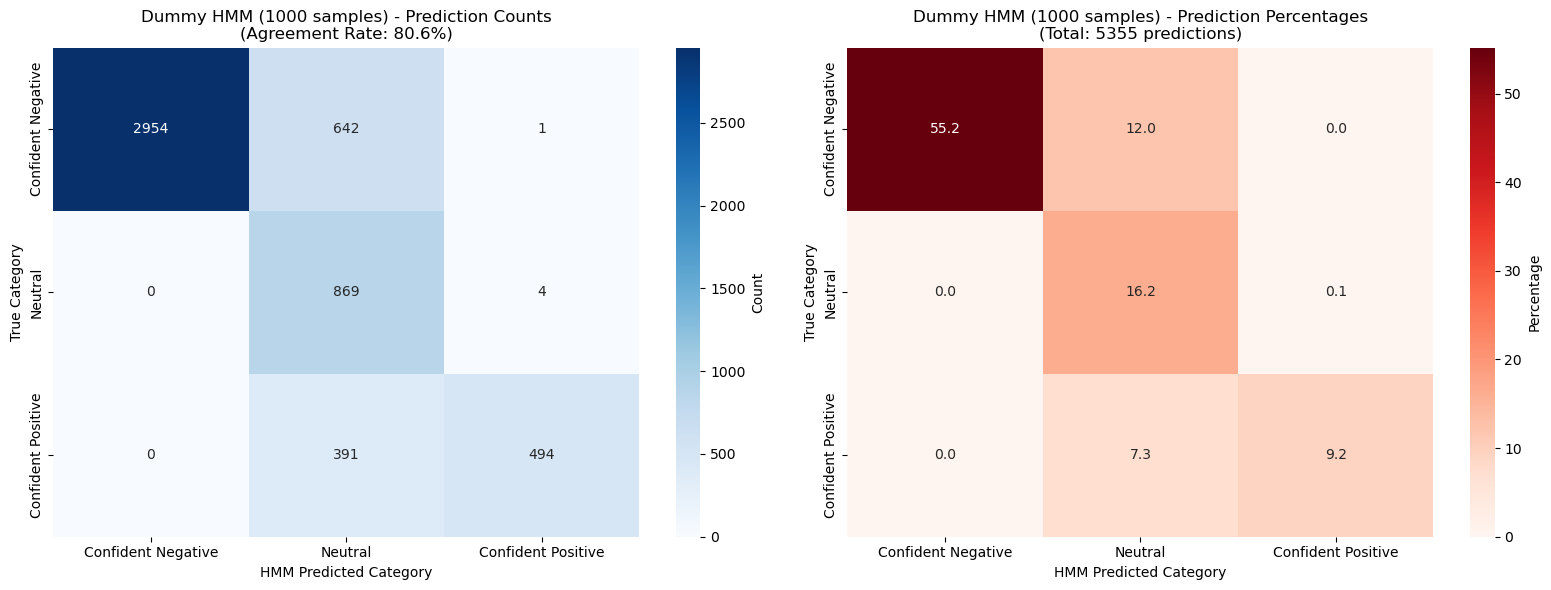


COMPARATIVE DISAGREEMENT ANALYSIS

=== COMPARING DISAGREEMENT PATTERNS: Main-HMM (25k) vs Dummy-HMM (1000k) ===
Calculating detailed fidelity metrics...


100%|██████████| 20/20 [00:03<00:00,  6.52it/s]



--- Detailed Fidelity Analysis (5355 steps evaluated) ---

True Confident Negative:
  Count: 3597
  KL Divergence - Mean: 0.0705, Std: 0.1515, Median: 0.0037
  NLL - Mean: 0.1838, Std: 0.2437, Median: 0.0770

True Neutral:
  Count: 873
  KL Divergence - Mean: 0.0477, Std: 0.0479, Median: 0.0307
  NLL - Mean: 0.6939, Std: 0.0170, Median: 0.6929

True Confident Positive:
  Count: 885
  KL Divergence - Mean: 0.1626, Std: 0.1724, Median: 0.1315
  NLL - Mean: 0.4110, Std: 0.2802, Median: 0.6045

Overall:
  KL Divergence - Mean: 0.0820, Std: 0.1485
  NLL - Mean: 0.3045, Std: 0.2988
Calculating detailed fidelity metrics...


100%|██████████| 20/20 [00:03<00:00,  6.57it/s]



--- Detailed Fidelity Analysis (5355 steps evaluated) ---

True Confident Negative:
  Count: 3597
  KL Divergence - Mean: 0.0638, Std: 0.1438, Median: 0.0037
  NLL - Mean: 0.1771, Std: 0.2343, Median: 0.0770

True Neutral:
  Count: 873
  KL Divergence - Mean: 0.0497, Std: 0.0505, Median: 0.0332
  NLL - Mean: 0.6958, Std: 0.0240, Median: 0.6947

True Confident Positive:
  Count: 885
  KL Divergence - Mean: 0.1459, Std: 0.1717, Median: 0.0168
  NLL - Mean: 0.3943, Std: 0.2902, Median: 0.2326

Overall:
  KL Divergence - Mean: 0.0751, Std: 0.1421
  NLL - Mean: 0.2976, Std: 0.2967

=== PREDICTION DISAGREEMENT ANALYSIS ===
Analyzing 5355 predictions...
Total disagreements: 1105/5355 (20.6%)
Agreement rate: 79.4%

DISAGREEMENT BREAKDOWN:

Most common disagreement patterns:
  Confident Negative → Neutral: 648 cases (58.6% of disagreements), Avg KL: 0.375
  Confident Positive → Neutral: 454 cases (41.1% of disagreements), Avg KL: 0.309
  Neutral → Confident Positive: 3 cases (0.3% of disagreem

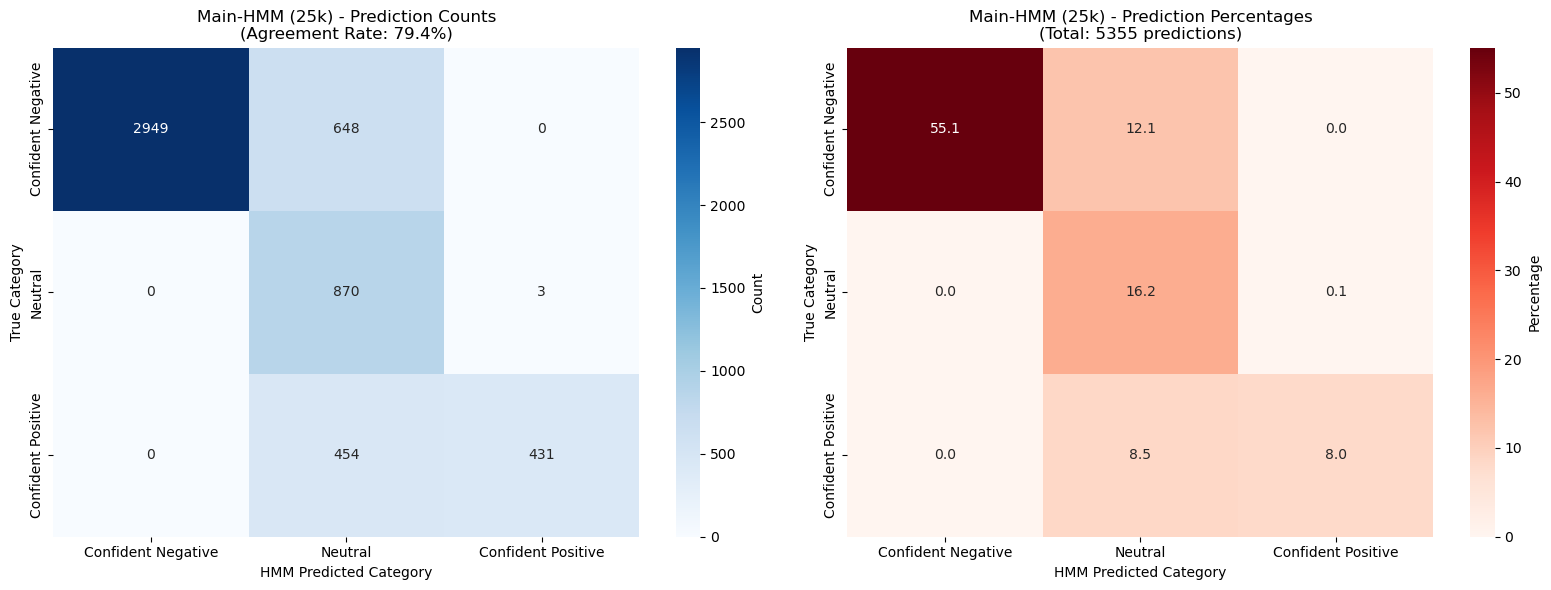

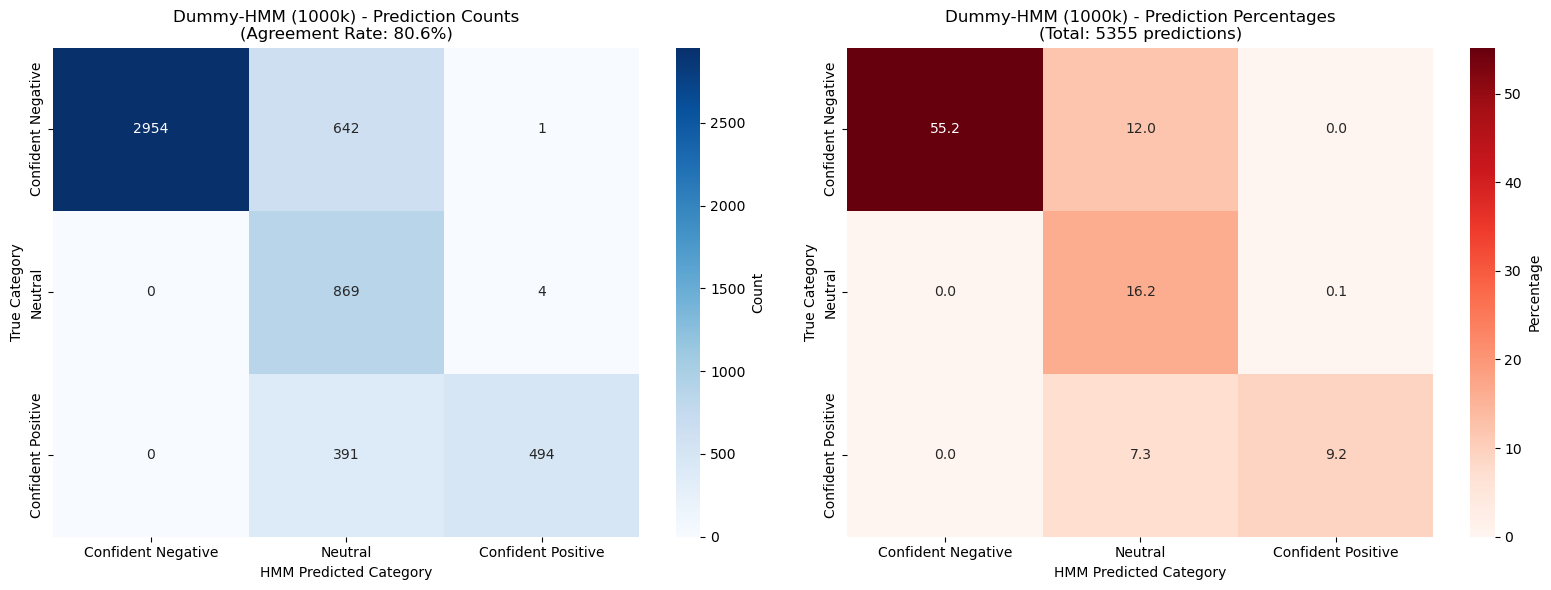

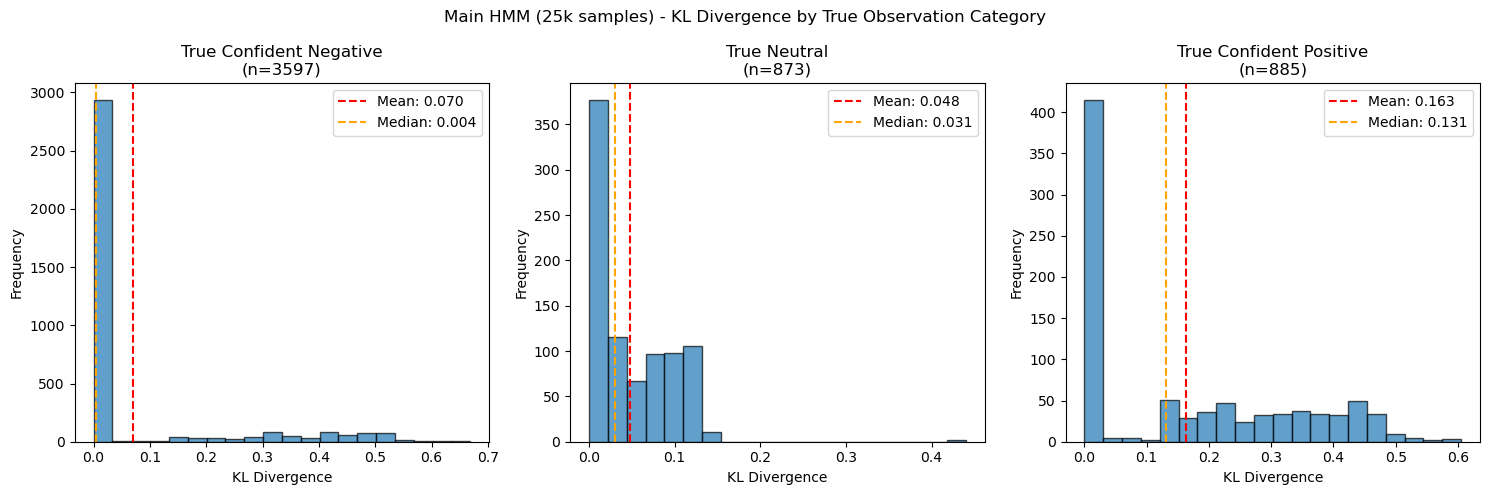

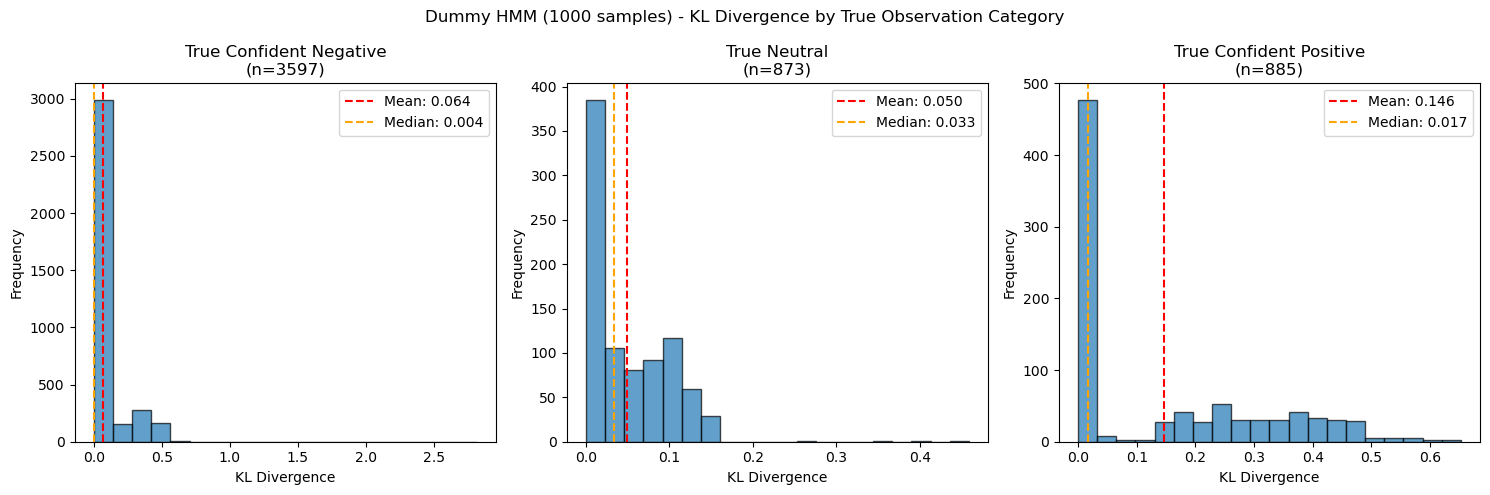


✓ Detailed results saved to data/detailed_analysis/

DETAILED ANALYSIS COMPLETE


In [7]:
# Detailed KL Divergence Analysis with Disagreement Heatmaps
print("="*80)
print("DETAILED FIDELITY ANALYSIS WITH PREDICTION DISAGREEMENT PATTERNS")
print("="*80)

if (hmm_surrogate_model and hmm_surrogate_model.is_trained and 
    dummy_hmm_model and dummy_hmm_model.is_trained and 
    fidelity_evaluation_set):
    
    # Perform detailed comparison between the two models
    print(f"\nComparing Main HMM (25k samples) vs Dummy HMM ({NUM_TRAIN_SAMPLES_FOR_DUMMY_HMM} samples)")
    print(f"Test set: {len(fidelity_evaluation_set)} sequences")
    
    try:
        # Compare models directly with detailed analysis
        comparison_results, results_main, results_dummy = hmm_surrogate_model.compare_hmm_performance(
            dummy_hmm_model, 
            fidelity_evaluation_set, 
            model_names=("Main-HMM (25k)", f"Dummy-HMM ({NUM_TRAIN_SAMPLES_FOR_DUMMY_HMM}k)")
        )
        
        # Additional detailed analysis
        print("\n" + "="*60)
        print("DETAILED BREAKDOWN BY PREDICTION DIFFICULTY")
        print("="*60)
        
        if results_main and results_dummy:
            # Analyze which model struggles more with which types of predictions
            categories = ["True Confident Negative", "True Neutral", "True Confident Positive"]
            
            print("\nPERFORMANCE INSIGHTS:")
            for category in categories:
                main_data = results_main['by_category'][category]
                dummy_data = results_dummy['by_category'][category]
                
                if main_data['count'] > 0 and dummy_data['count'] > 0:
                    main_kl = main_data['avg_kl']
                    dummy_kl = dummy_data['avg_kl']
                    improvement = ((dummy_kl - main_kl) / dummy_kl) * 100 if dummy_kl > 0 else 0
                    
                    print(f"\n{category}:")
                    print(f"  Main HMM:  {main_kl:.4f} ± {main_data['std_kl']:.4f} (n={main_data['count']})")
                    print(f"  Dummy HMM: {dummy_kl:.4f} ± {dummy_data['std_kl']:.4f} (n={dummy_data['count']})")
                    
                    if improvement > 0:
                        print(f"  → Main HMM is {improvement:.1f}% better on {category.lower()}")
                    else:
                        print(f"  → Dummy HMM is {-improvement:.1f}% better on {category.lower()}")
                    
                    # Check if difference is substantial
                    if abs(main_kl - dummy_kl) > 0.1:
                        if main_kl < dummy_kl:
                            print(f"  ★ Main HMM shows STRONG advantage on {category.lower()}")
                        else:
                            print(f"  ★ Dummy HMM shows STRONG advantage on {category.lower()}")
        
        # NEW: Disagreement Pattern Analysis with Heatmaps
        print(f"\n{'='*60}")
        print("PREDICTION DISAGREEMENT ANALYSIS")
        print(f"{'='*60}")
        
        if results_main:
            print("\nAnalyzing Main HMM disagreement patterns...")
            disagreement_main, fig_main_disagree = hmm_surrogate_model.analyze_prediction_disagreements(
                results_main, "Main HMM (25k samples)")
            plt.show()
            
        if results_dummy:
            print(f"\nAnalyzing Dummy HMM disagreement patterns...")
            disagreement_dummy, fig_dummy_disagree = dummy_hmm_model.analyze_prediction_disagreements(
                results_dummy, f"Dummy HMM ({NUM_TRAIN_SAMPLES_FOR_DUMMY_HMM} samples)")
            plt.show()
        
        # Compare disagreement patterns between models
        if results_main and results_dummy:
            print(f"\n{'='*60}")
            print("COMPARATIVE DISAGREEMENT ANALYSIS")
            print(f"{'='*60}")
            
            disagreement_comparison = hmm_surrogate_model.compare_disagreement_patterns(
                dummy_hmm_model, 
                fidelity_evaluation_set,
                model_names=("Main-HMM (25k)", f"Dummy-HMM ({NUM_TRAIN_SAMPLES_FOR_DUMMY_HMM}k)")
            )
        
        # Overall performance summary
        if results_main and results_dummy:
            print(f"\n{'='*40}")
            print("OVERALL PERFORMANCE SUMMARY")
            print(f"{'='*40}")
            
            main_overall = results_main['overall']['avg_kl']
            dummy_overall = results_dummy['overall']['avg_kl']
            overall_improvement = ((dummy_overall - main_overall) / dummy_overall) * 100
            
            print(f"Main HMM overall:  {main_overall:.4f}")
            print(f"Dummy HMM overall: {dummy_overall:.4f}")
            print(f"Overall improvement: {overall_improvement:.1f}%")
            
            if overall_improvement > 10:
                print("→ Main HMM shows SIGNIFICANT overall improvement")
            elif overall_improvement > 5:
                print("→ Main HMM shows moderate overall improvement")
            elif overall_improvement > -5:
                print("→ Models perform similarly overall")
            elif overall_improvement > -10:
                print("→ Dummy HMM shows moderate overall improvement")
            else:
                print("→ Dummy HMM shows SIGNIFICANT overall improvement")
        
        # Visualization of KL distributions
        try:
            print(f"\n{'='*40}")
            print("KL DIVERGENCE DISTRIBUTION PLOTS")
            print(f"{'='*40}")
            
            # Plot KL distributions for both models
            if results_main:
                fig_main = hmm_surrogate_model.plot_kl_distributions(results_main, "Main HMM (25k samples)")
                plt.show()
                
            if results_dummy:
                fig_dummy = dummy_hmm_model.plot_kl_distributions(results_dummy, f"Dummy HMM ({NUM_TRAIN_SAMPLES_FOR_DUMMY_HMM} samples)")
                plt.show()
                
        except Exception as e:
            print(f"Could not generate KL distribution plots: {e}")
            
        # Save detailed results for further analysis
        try:
            if not os.path.exists('data/detailed_analysis'):
                os.makedirs('data/detailed_analysis')
                
            with open('data/detailed_analysis/main_hmm_detailed_results.pkl', 'wb') as f:
                pickle.dump(results_main, f)
            with open('data/detailed_analysis/dummy_hmm_detailed_results.pkl', 'wb') as f:
                pickle.dump(results_dummy, f)
            with open('data/detailed_analysis/comparison_results.pkl', 'wb') as f:
                pickle.dump(comparison_results, f)
            if 'disagreement_comparison' in locals():
                with open('data/detailed_analysis/disagreement_comparison.pkl', 'wb') as f:
                    pickle.dump(disagreement_comparison, f)
                
            print(f"\n✓ Detailed results saved to data/detailed_analysis/")
            
        except Exception as e:
            print(f"Could not save detailed results: {e}")
            
    except Exception as e:
        print(f"Error during detailed analysis: {e}")
        print("Attempting individual model analysis...")
        
        # Fallback: analyze each model individually
        try:
            print("\nAnalyzing Main HMM individually...")
            results_main = hmm_surrogate_model.calculate_detailed_fidelity_metrics(fidelity_evaluation_set)
            disagreement_main, fig_main = hmm_surrogate_model.analyze_prediction_disagreements(results_main, "Main HMM")
            plt.show()
            
            print("\nAnalyzing Dummy HMM individually...")
            results_dummy = dummy_hmm_model.calculate_detailed_fidelity_metrics(fidelity_evaluation_set)
            disagreement_dummy, fig_dummy = dummy_hmm_model.analyze_prediction_disagreements(results_dummy, "Dummy HMM")
            plt.show()
            
        except Exception as e2:
            print(f"Individual analysis also failed: {e2}")

else:
    print("Cannot perform detailed analysis - missing required models or test data:")
    print(f"  Main HMM trained: {hmm_surrogate_model.is_trained if hmm_surrogate_model else False}")
    print(f"  Dummy HMM trained: {dummy_hmm_model.is_trained if dummy_hmm_model else False}")
    print(f"  Test data available: {len(fidelity_evaluation_set) if fidelity_evaluation_set else 0} sequences")

print("\n" + "="*80)
print("DETAILED ANALYSIS COMPLETE")
print("="*80)

# NOTE
The model trained on 25k samples (HMM25k) is worse than the model trained on 1k samples (HMM1k) because HMM25k is more conservative in transitioning from neutral to positive. This can be understood by looking to the colored reviews: tokens which the transformer model is more confident about (higher p(pos)) not always have a higher p(pos) in HMM25k. THIS IS GOOD! because, reading the reviews, those tokens should not be positive, from a human stand point the HMM25k is more faithful. The HMM1k is more faithful to the transformer model, so it has lower kl divergence.

In [ ]:
# save color logs for clustering
save_color_log()